In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

import optuna
from optuna.samplers import TPESampler, GPSampler
from optuna import visualization

In [2]:
df = pd.read_csv("../data/NiB/inchi_23l.csv")

In [3]:
# リストの作成
electrophile_list = df['electrophile_inchi'].unique().tolist()
ligand_list = df['ligand_inchi'].unique().tolist()
solvent_list = df['solvent_inchi'].unique().tolist()

print(f"  Electrophiles: {len(electrophile_list)}")
print(f"  Ligands: {len(ligand_list)}")
print(f"  Solvents: {len(solvent_list)}")
print(f"  総組み合わせ数: {len(electrophile_list) * len(ligand_list) * len(solvent_list):,}")

# 辞書の作成
keys = list(zip(df['electrophile_inchi'], df['ligand_inchi'], df['solvent_inchi']))
product_dict = dict(zip(keys, df['product_inchi']))
yield_dict = dict(zip(keys, df['yield']))

  Electrophiles: 33
  Ligands: 23
  Solvents: 2
  総組み合わせ数: 1,518


In [4]:
#目的関数の定義
def objective(trial):
    """
    反応収率を最適化する目的関数
    """
    # 各反応成分のカテゴリパラメータをサンプリング
    electrophile_inchi = trial.suggest_categorical('electrophile_inchi', electrophile_list)
    ligand_inchi = trial.suggest_categorical('ligand_inchi', ligand_list)
    solvent_inchi = trial.suggest_categorical('solvent_inchi', solvent_list)
    
    # 検索キーの作成
    key = (electrophile_inchi, ligand_inchi, solvent_inchi)
    
    # 実験データから収率を取得
    if key in yield_dict:
        yield_value = yield_dict[key]
    else:
        # 未知の組み合わせには0を返す（このデータセットでは発生しない）
        yield_value = 0.0
    
    # 後の分析用に追加情報を保存
    trial.set_user_attr('electrophile_inchi', electrophile_inchi)
    trial.set_user_attr('ligand_inchi', ligand_inchi)
    trial.set_user_attr('solvent_inchi', solvent_inchi)
    trial.set_user_attr('yield', yield_value)
    
    return yield_value

## TPE Sampler

In [5]:
def run_tpe_optimization(n_trials=42, seed=123, db_path="../runs/optuna_tpe_100trials_NiB/optuna_tpe_100trials_NiB.db"):
    """
    反応収率最大化のためのTPE最適化を実行

    Args:
        n_trials (int): 最適化試行回数
        seed (int): 再現性のためのランダムシード
        db_path (str): 結果保存用SQLiteデータベースのパス

    Returns:
        optuna.Study: 完了した最適化スタディ
    """

    # 出力ディレクトリの作成
    os.makedirs(os.path.dirname(db_path), exist_ok=True)
    
    # TPEサンプラーを設定
    sampler = TPESampler(
        n_startup_trials=10,    # 初期探索用のランダムサンプリング
        n_ei_candidates=24,     # 期待改善候補数
        seed=seed               # 再現可能な結果を保証
    )
    
    # 新規スタディの作成または既存スタディの読み込み
    study = optuna.create_study(
        direction='maximize',                    # 収率を最大化
        sampler=sampler,                        # TPEサンプラーを使用
        study_name='tpe_yield_optimization_NiB',
        storage=f"sqlite:///{db_path}",         # 永続化ストレージ
    )
    
    # 最適化の実行
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    # 最適化結果の表示
    print("最適化完了")
    print(f"最良の収率: {study.best_value:.2f}%")
    print("最適な反応条件:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    print(f"最適化結果の保存先: {db_path}")
    return study

In [6]:
study = run_tpe_optimization(n_trials=100, seed=42)

[I 2025-09-25 06:18:45,540] A new study created in RDB with name: tpe_yield_optimization_NiB
Best trial: 0. Best value: 37.6993:   2%|▏         | 2/100 [00:00<00:14,  6.73it/s]

[I 2025-09-25 06:18:45,698] Trial 0 finished with value: 37.699250000000006 and parameters: {'electrophile_inchi': 'InChI=1S/C9H12BrNO2/c1-3-11-6-7(10)5-8(11)9(12)13-4-2/h5-6H,3-4H2,1-2H3', 'ligand_inchi': 'InChI=1S/C18H12F3P/c19-13-1-7-16(8-2-13)22(17-9-3-14(20)4-10-17)18-11-5-15(21)6-12-18/h1-12H', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 0 with value: 37.699250000000006.
[I 2025-09-25 06:18:45,838] Trial 1 finished with value: 23.52475 and parameters: {'electrophile_inchi': 'InChI=1S/C9H12BrNO2/c1-3-11-6-7(10)5-8(11)9(12)13-4-2/h5-6H,3-4H2,1-2H3', 'ligand_inchi': 'InChI=1S/C24H27P/c1-16-7-17(2)11-22(10-16)25(23-12-18(3)8-19(4)13-23)24-14-20(5)9-21(6)15-24/h7-15H,1-6H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 0 with value: 37.699250000000006.


Best trial: 3. Best value: 69.855:   4%|▍         | 4/100 [00:00<00:14,  6.85it/s] 

[I 2025-09-25 06:18:45,986] Trial 2 finished with value: 50.93 and parameters: {'electrophile_inchi': 'InChI=1S/C7H6ClFO/c1-10-7-4-5(8)2-3-6(7)9/h2-4H,1H3', 'ligand_inchi': 'InChI=1S/C30H34NP/c1-3-13-23(14-4-1)32(24-15-5-2-6-16-24)30-22-12-11-21-29(30)31-27-19-9-7-17-25(27)26-18-8-10-20-28(26)31/h7-12,17-24H,1-6,13-16H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 2 with value: 50.93.
[I 2025-09-25 06:18:46,129] Trial 3 finished with value: 69.855 and parameters: {'electrophile_inchi': 'InChI=1S/C10H12N2O3S2/c1-7-11-9-6-8(4-5-10(9)16-7)15-17(13,14)12(2)3/h4-6H,1-3H3', 'ligand_inchi': 'InChI=1S/C18H15P/c1-4-10-16(11-5-1)19(17-12-6-2-7-13-17)18-14-8-3-9-15-18/h1-15H', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 3 with value: 69.855.


Best trial: 3. Best value: 69.855:   6%|▌         | 6/100 [00:00<00:13,  6.79it/s]

[I 2025-09-25 06:18:46,284] Trial 4 finished with value: 17.87 and parameters: {'electrophile_inchi': 'InChI=1S/C7H6ClFO/c1-10-7-3-2-5(8)4-6(7)9/h2-4H,1H3', 'ligand_inchi': 'InChI=1S/C35H39OP/c1-36-31-23-13-12-22-30(31)34-32-26-18-8-10-20-28(26)33(29-21-11-9-19-27(29)32)35(34)37(24-14-4-2-5-15-24)25-16-6-3-7-17-25/h8-13,18-25,32-33H,2-7,14-17H2,1H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 3 with value: 69.855.
[I 2025-09-25 06:18:46,427] Trial 5 finished with value: 39.19 and parameters: {'electrophile_inchi': 'InChI=1S/C9H6BrN/c10-8-5-7-3-1-2-4-9(7)11-6-8/h1-6H', 'ligand_inchi': 'InChI=1S/C29H39P.BF4/c1-2-3-22-29(27-20-12-10-18-25(27)26-19-11-13-21-28(26)29)30(23-14-6-4-7-15-23)24-16-8-5-9-17-24;2-1(3,4)5/h10-13,18-21,23-24H,2-9,14-17,22H2,1H3;/q;-1/p+1', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 3 with value: 69.855.


Best trial: 6. Best value: 70.2032:   8%|▊         | 8/100 [00:01<00:13,  6.73it/s]

[I 2025-09-25 06:18:46,574] Trial 6 finished with value: 70.20319063751154 and parameters: {'electrophile_inchi': 'InChI=1S/C7H6BrFO/c1-10-7-3-2-5(8)4-6(7)9/h2-4H,1H3', 'ligand_inchi': 'InChI=1S/C25H33P/c1-20-12-8-9-17-23(20)24-18-10-11-19-25(24)26(21-13-4-2-5-14-21)22-15-6-3-7-16-22/h8-12,17-19,21-22H,2-7,13-16H2,1H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 6 with value: 70.20319063751154.
[I 2025-09-25 06:18:46,727] Trial 7 finished with value: 6.03 and parameters: {'electrophile_inchi': 'InChI=1S/C7H8ClN/c1-5-6(8)3-2-4-7(5)9/h2-4H,9H2,1H3', 'ligand_inchi': 'InChI=1S/C22H30NP/c1-4-11-19(12-5-1)23-18-10-17-22(23)24(20-13-6-2-7-14-20)21-15-8-3-9-16-21/h1,4-5,10-12,17-18,20-21H,2-3,6-9,13-16H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 6 with value: 70.20319063751154.


Best trial: 6. Best value: 70.2032:  10%|█         | 10/100 [00:01<00:13,  6.66it/s]

[I 2025-09-25 06:18:46,871] Trial 8 finished with value: 42.93 and parameters: {'electrophile_inchi': 'InChI=1S/C9H12BrNO2/c1-3-11-6-7(10)5-8(11)9(12)13-4-2/h5-6H,3-4H2,1-2H3', 'ligand_inchi': 'InChI=1S/C24H27P/c1-16-7-17(2)11-22(10-16)25(23-12-18(3)8-19(4)13-23)24-14-20(5)9-21(6)15-24/h7-15H,1-6H3', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 6 with value: 70.20319063751154.
[I 2025-09-25 06:18:47,028] Trial 9 finished with value: 10.525 and parameters: {'electrophile_inchi': 'InChI=1S/C9H10ClNO/c1-11(2)9(12)7-3-5-8(10)6-4-7/h3-6H,1-2H3', 'ligand_inchi': 'InChI=1S/C14H23P/c1-13(2,3)15(14(4,5)6)12-10-8-7-9-11-12/h7-11H,1-6H3', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 6 with value: 70.20319063751154.


Best trial: 6. Best value: 70.2032:  12%|█▏        | 12/100 [00:01<00:13,  6.70it/s]

[I 2025-09-25 06:18:47,178] Trial 10 finished with value: 39.773304588851246 and parameters: {'electrophile_inchi': 'InChI=1S/C7H6BrFO/c1-10-7-3-2-5(8)4-6(7)9/h2-4H,1H3', 'ligand_inchi': 'InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 6 with value: 70.20319063751154.
[I 2025-09-25 06:18:47,325] Trial 11 finished with value: 52.69 and parameters: {'electrophile_inchi': 'InChI=1S/C10H12N2O3S2/c1-7-11-9-6-8(4-5-10(9)16-7)15-17(13,14)12(2)3/h4-6H,1-3H3', 'ligand_inchi': 'InChI=1S/C18H15P/c1-4-10-16(11-5-1)19(17-12-6-2-7-13-17)18-14-8-3-9-15-18/h1-15H', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 6 with value: 70.20319063751154.


Best trial: 6. Best value: 70.2032:  14%|█▍        | 14/100 [00:02<00:13,  6.40it/s]

[I 2025-09-25 06:18:47,484] Trial 12 finished with value: 42.08 and parameters: {'electrophile_inchi': 'InChI=1S/C10H12N2O3S/c1-12(2)16(13,14)15-9-3-4-10-8(7-9)5-6-11-10/h3-7,11H,1-2H3', 'ligand_inchi': 'InChI=1S/C25H33P/c1-20-12-8-9-17-23(20)24-18-10-11-19-25(24)26(21-13-4-2-5-14-21)22-15-6-3-7-16-22/h8-12,17-19,21-22H,2-7,13-16H2,1H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 6 with value: 70.20319063751154.
[I 2025-09-25 06:18:47,648] Trial 13 finished with value: 59.32 and parameters: {'electrophile_inchi': 'InChI=1S/C8H7BrO2/c1-11-8(10)6-2-4-7(9)5-3-6/h2-5H,1H3', 'ligand_inchi': 'InChI=1S/C25H33P/c1-20-12-8-9-17-23(20)24-18-10-11-19-25(24)26(21-13-4-2-5-14-21)22-15-6-3-7-16-22/h8-12,17-19,21-22H,2-7,13-16H2,1H3', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 6 with value: 70.20319063751154.


Best trial: 6. Best value: 70.2032:  16%|█▌        | 16/100 [00:02<00:13,  6.35it/s]

[I 2025-09-25 06:18:47,815] Trial 14 finished with value: 0.0999999999999999 and parameters: {'electrophile_inchi': 'InChI=1S/C10H12N2O3S2/c1-7-11-9-6-8(4-5-10(9)16-7)15-17(13,14)12(2)3/h4-6H,1-3H3', 'ligand_inchi': 'InChI=1S/C26H23O2P/c1-27-23-17-11-18-24(28-2)26(23)22-16-9-10-19-25(22)29(20-12-5-3-6-13-20)21-14-7-4-8-15-21/h3-19H,1-2H3', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 6 with value: 70.20319063751154.
[I 2025-09-25 06:18:47,968] Trial 15 finished with value: 24.44 and parameters: {'electrophile_inchi': 'InChI=1S/C7H7BrO/c1-9-7-4-2-6(8)3-5-7/h2-5H,1H3', 'ligand_inchi': 'InChI=1S/C18H33P.BF4/c1-4-10-16(11-5-1)19(17-12-6-2-7-13-17)18-14-8-3-9-15-18;2-1(3,4)5/h16-18H,1-15H2;/q;-1/p+1', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 6 with value: 70.20319063751154.


Best trial: 6. Best value: 70.2032:  18%|█▊        | 18/100 [00:02<00:11,  7.04it/s]

[I 2025-09-25 06:18:48,127] Trial 16 finished with value: 0.28 and parameters: {'electrophile_inchi': 'InChI=1S/C8H9Cl/c1-6-4-3-5-7(2)8(6)9/h3-5H,1-2H3', 'ligand_inchi': 'InChI=1S/C36H39N4P/c1-6-16-28(17-7-1)34-36(35(29-18-8-2-9-19-29)39(38-34)30-20-10-3-11-21-30)40-33(26-27-37-40)41(31-22-12-4-13-23-31)32-24-14-5-15-25-32/h1-3,6-11,16-21,26-27,31-32H,4-5,12-15,22-25H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 6 with value: 70.20319063751154.
[I 2025-09-25 06:18:48,232] Trial 17 finished with value: 62.625 and parameters: {'electrophile_inchi': 'InChI=1S/C4H3BrS/c5-4-1-2-6-3-4/h1-3H', 'ligand_inchi': 'InChI=1S/C18H15P/c1-4-10-16(11-5-1)19(17-12-6-2-7-13-17)18-14-8-3-9-15-18/h1-15H', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 6 with value: 70.20319063751154.


Best trial: 18. Best value: 82.11:  20%|██        | 20/100 [00:02<00:10,  7.30it/s] 

[I 2025-09-25 06:18:48,359] Trial 18 finished with value: 82.11 and parameters: {'electrophile_inchi': 'InChI=1S/C9H6ClN/c10-8-5-7-3-1-2-4-9(7)11-6-8/h1-6H', 'ligand_inchi': 'InChI=1S/C21H21O3P/c1-22-16-4-10-19(11-5-16)25(20-12-6-17(23-2)7-13-20)21-14-8-18(24-3)9-15-21/h4-15H,1-3H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 18 with value: 82.11.
[I 2025-09-25 06:18:48,495] Trial 19 finished with value: 57.22 and parameters: {'electrophile_inchi': 'InChI=1S/C9H6ClN/c10-8-5-7-3-1-2-4-9(7)11-6-8/h1-6H', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 18 with value: 82.11.


Best trial: 20. Best value: 90.49:  22%|██▏       | 22/100 [00:03<00:10,  7.14it/s]

[I 2025-09-25 06:18:48,634] Trial 20 finished with value: 90.49 and parameters: {'electrophile_inchi': 'InChI=1S/C7H3ClFN/c8-6-2-1-5(4-10)7(9)3-6/h1-3H', 'ligand_inchi': 'InChI=1S/C21H21O3P/c1-22-16-4-10-19(11-5-16)25(20-12-6-17(23-2)7-13-20)21-14-8-18(24-3)9-15-21/h4-15H,1-3H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 20 with value: 90.49.
[I 2025-09-25 06:18:48,779] Trial 21 finished with value: 90.49 and parameters: {'electrophile_inchi': 'InChI=1S/C7H3ClFN/c8-6-2-1-5(4-10)7(9)3-6/h1-3H', 'ligand_inchi': 'InChI=1S/C21H21O3P/c1-22-16-4-10-19(11-5-16)25(20-12-6-17(23-2)7-13-20)21-14-8-18(24-3)9-15-21/h4-15H,1-3H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 20 with value: 90.49.


Best trial: 20. Best value: 90.49:  24%|██▍       | 24/100 [00:03<00:10,  7.09it/s]

[I 2025-09-25 06:18:48,924] Trial 22 finished with value: 90.49 and parameters: {'electrophile_inchi': 'InChI=1S/C7H3ClFN/c8-6-2-1-5(4-10)7(9)3-6/h1-3H', 'ligand_inchi': 'InChI=1S/C21H21O3P/c1-22-16-4-10-19(11-5-16)25(20-12-6-17(23-2)7-13-20)21-14-8-18(24-3)9-15-21/h4-15H,1-3H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 20 with value: 90.49.
[I 2025-09-25 06:18:49,064] Trial 23 finished with value: 90.49 and parameters: {'electrophile_inchi': 'InChI=1S/C7H3ClFN/c8-6-2-1-5(4-10)7(9)3-6/h1-3H', 'ligand_inchi': 'InChI=1S/C21H21O3P/c1-22-16-4-10-19(11-5-16)25(20-12-6-17(23-2)7-13-20)21-14-8-18(24-3)9-15-21/h4-15H,1-3H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 20 with value: 90.49.


Best trial: 20. Best value: 90.49:  26%|██▌       | 26/100 [00:03<00:10,  7.17it/s]

[I 2025-09-25 06:18:49,205] Trial 24 finished with value: 90.49 and parameters: {'electrophile_inchi': 'InChI=1S/C7H3ClFN/c8-6-2-1-5(4-10)7(9)3-6/h1-3H', 'ligand_inchi': 'InChI=1S/C21H21O3P/c1-22-16-4-10-19(11-5-16)25(20-12-6-17(23-2)7-13-20)21-14-8-18(24-3)9-15-21/h4-15H,1-3H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 20 with value: 90.49.
[I 2025-09-25 06:18:49,340] Trial 25 finished with value: 48.97 and parameters: {'electrophile_inchi': 'InChI=1S/C7H3ClFN/c8-6-2-1-5(4-10)7(9)3-6/h1-3H', 'ligand_inchi': 'InChI=1S/C21H21O3P/c1-22-16-10-4-7-13-19(16)25(20-14-8-5-11-17(20)23-2)21-15-9-6-12-18(21)24-3/h4-15H,1-3H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 20 with value: 90.49.


Best trial: 20. Best value: 90.49:  28%|██▊       | 28/100 [00:04<00:10,  7.10it/s]

[I 2025-09-25 06:18:49,480] Trial 26 finished with value: 30.69 and parameters: {'electrophile_inchi': 'InChI=1S/C7H5BrO2/c8-5-1-2-6-7(3-5)10-4-9-6/h1-3H,4H2', 'ligand_inchi': 'InChI=1S/C21H21O3P/c1-22-16-4-10-19(11-5-16)25(20-12-6-17(23-2)7-13-20)21-14-8-18(24-3)9-15-21/h4-15H,1-3H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 20 with value: 90.49.
[I 2025-09-25 06:18:49,624] Trial 27 finished with value: 62.96 and parameters: {'electrophile_inchi': 'InChI=1S/C7H3ClFN/c8-6-2-1-5(4-10)7(9)3-6/h1-3H', 'ligand_inchi': 'InChI=1S/C27H35P/c1-22(27(23-14-6-2-7-15-23)24-16-8-3-9-17-24)28(25-18-10-4-11-19-25)26-20-12-5-13-21-26/h2-3,6-9,14-17,25-26H,4-5,10-13,18-21H2,1H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 20 with value: 90.49.


Best trial: 20. Best value: 90.49:  30%|███       | 30/100 [00:04<00:09,  7.12it/s]

[I 2025-09-25 06:18:49,766] Trial 28 finished with value: 89.17 and parameters: {'electrophile_inchi': 'InChI=1S/C8H6ClN/c9-7-1-2-8-6(5-7)3-4-10-8/h1-5,10H', 'ligand_inchi': 'InChI=1S/C26H32NP/c1-4-12-21(13-5-1)26-20-22-14-10-11-19-25(22)27(26)28(23-15-6-2-7-16-23)24-17-8-3-9-18-24/h1,4-5,10-14,19-20,23-24H,2-3,6-9,15-18H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 20 with value: 90.49.
[I 2025-09-25 06:18:49,905] Trial 29 finished with value: 25.37 and parameters: {'electrophile_inchi': 'InChI=1S/C14H15NO3S/c1-15(2)19(16,17)18-14-10-8-13(9-11-14)12-6-4-3-5-7-12/h3-11H,1-2H3', 'ligand_inchi': 'InChI=1S/C33H37P/c1-23(2)26-21-30(24(3)4)33(31(22-26)25(5)6)29-19-13-14-20-32(29)34(27-15-9-7-10-16-27)28-17-11-8-12-18-28/h7-25H,1-6H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 20 with value: 90.49.


Best trial: 20. Best value: 90.49:  32%|███▏      | 32/100 [00:04<00:09,  7.06it/s]

[I 2025-09-25 06:18:50,046] Trial 30 finished with value: 42.72 and parameters: {'electrophile_inchi': 'InChI=1S/C7H3BrFN/c8-6-2-1-5(4-10)7(9)3-6/h1-3H', 'ligand_inchi': 'InChI=1S/C33H49OP/c1-32(2,3)24-22-28(33(4,5)6)31(29(23-24)34-7)27-20-14-15-21-30(27)35(25-16-10-8-11-17-25)26-18-12-9-13-19-26/h14-15,20-23,25-26H,8-13,16-19H2,1-7H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 20 with value: 90.49.
[I 2025-09-25 06:18:50,189] Trial 31 finished with value: 90.49 and parameters: {'electrophile_inchi': 'InChI=1S/C7H3ClFN/c8-6-2-1-5(4-10)7(9)3-6/h1-3H', 'ligand_inchi': 'InChI=1S/C21H21O3P/c1-22-16-4-10-19(11-5-16)25(20-12-6-17(23-2)7-13-20)21-14-8-18(24-3)9-15-21/h4-15H,1-3H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 20 with value: 90.49.


Best trial: 20. Best value: 90.49:  34%|███▍      | 34/100 [00:04<00:09,  7.04it/s]

[I 2025-09-25 06:18:50,328] Trial 32 finished with value: 37.63 and parameters: {'electrophile_inchi': 'InChI=1S/C9H8ClFO2/c1-2-13-9(12)6-3-4-7(10)8(11)5-6/h3-5H,2H2,1H3', 'ligand_inchi': 'InChI=1S/C26H24NP/c1-27(2)25-19-11-9-17-23(25)24-18-10-12-20-26(24)28(21-13-5-3-6-14-21)22-15-7-4-8-16-22/h3-20H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 20 with value: 90.49.
[I 2025-09-25 06:18:50,474] Trial 33 finished with value: 33.01 and parameters: {'electrophile_inchi': 'InChI=1S/C7H5ClO2/c8-5-1-2-6-7(3-5)10-4-9-6/h1-3H,4H2', 'ligand_inchi': 'InChI=1S/C18H21P/c1-4-10-16(11-5-1)19(17-12-6-2-7-13-17)18-14-8-3-9-15-18/h1-2,4-7,10-13,18H,3,8-9,14-15H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 20 with value: 90.49.


Best trial: 20. Best value: 90.49:  36%|███▌      | 36/100 [00:05<00:09,  6.93it/s]

[I 2025-09-25 06:18:50,621] Trial 34 finished with value: 59.43 and parameters: {'electrophile_inchi': 'InChI=1S/C8H5BrO/c9-7-1-2-8-6(5-7)3-4-10-8/h1-5H', 'ligand_inchi': 'InChI=1S/C18H12F3P/c19-13-1-7-16(8-2-13)22(17-9-3-14(20)4-10-17)18-11-5-15(21)6-12-18/h1-12H', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 20 with value: 90.49.
[I 2025-09-25 06:18:50,767] Trial 35 finished with value: 9.94294541208524 and parameters: {'electrophile_inchi': 'InChI=1S/C12H9Cl/c13-12-8-6-11(7-9-12)10-4-2-1-3-5-10/h1-9H', 'ligand_inchi': 'InChI=1S/C3H9P.BF4/c1-4(2)3;2-1(3,4)5/h1-3H3;/q;-1/p+1', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 20 with value: 90.49.


Best trial: 20. Best value: 90.49:  38%|███▊      | 38/100 [00:05<00:08,  6.93it/s]

[I 2025-09-25 06:18:50,908] Trial 36 finished with value: 72.12 and parameters: {'electrophile_inchi': 'InChI=1S/C7H4ClF3/c8-6-3-1-5(2-4-6)7(9,10)11/h1-4H', 'ligand_inchi': 'InChI=1S/C21H21O3P/c1-22-16-4-10-19(11-5-16)25(20-12-6-17(23-2)7-13-20)21-14-8-18(24-3)9-15-21/h4-15H,1-3H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 20 with value: 90.49.
[I 2025-09-25 06:18:51,055] Trial 37 finished with value: 63.13 and parameters: {'electrophile_inchi': 'InChI=1S/C8H7ClO2/c1-11-8(10)6-2-4-7(9)5-3-6/h2-5H,1H3', 'ligand_inchi': 'InChI=1S/C21H21O3P/c1-22-16-4-10-19(11-5-16)25(20-12-6-17(23-2)7-13-20)21-14-8-18(24-3)9-15-21/h4-15H,1-3H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 20 with value: 90.49.


Best trial: 20. Best value: 90.49:  40%|████      | 40/100 [00:05<00:08,  7.04it/s]

[I 2025-09-25 06:18:51,193] Trial 38 finished with value: 81.42493419210305 and parameters: {'electrophile_inchi': 'InChI=1S/C12H9Br/c13-12-8-6-11(7-9-12)10-4-2-1-3-5-10/h1-9H', 'ligand_inchi': 'InChI=1S/C21H21O3P/c1-22-16-4-10-19(11-5-16)25(20-12-6-17(23-2)7-13-20)21-14-8-18(24-3)9-15-21/h4-15H,1-3H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 20 with value: 90.49.
[I 2025-09-25 06:18:51,333] Trial 39 finished with value: 26.045 and parameters: {'electrophile_inchi': 'InChI=1S/C7H6ClF/c1-5-4-6(9)2-3-7(5)8/h2-4H,1H3', 'ligand_inchi': 'InChI=1S/C29H39P.BF4/c1-2-3-22-29(27-20-12-10-18-25(27)26-19-11-13-21-28(26)29)30(23-14-6-4-7-15-23)24-16-8-5-9-17-24;2-1(3,4)5/h10-13,18-21,23-24H,2-9,14-17,22H2,1H3;/q;-1/p+1', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 20 with value: 90.49.


Best trial: 20. Best value: 90.49:  42%|████▏     | 42/100 [00:06<00:08,  7.16it/s]

[I 2025-09-25 06:18:51,470] Trial 40 finished with value: 65.99000000000001 and parameters: {'electrophile_inchi': 'InChI=1S/C7H4BrF3/c8-6-3-1-5(2-4-6)7(9,10)11/h1-4H', 'ligand_inchi': 'InChI=1S/C35H39OP/c1-36-31-23-13-12-22-30(31)34-32-26-18-8-10-20-28(26)33(29-21-11-9-19-27(29)32)35(34)37(24-14-4-2-5-15-24)25-16-6-3-7-17-25/h8-13,18-25,32-33H,2-7,14-17H2,1H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 20 with value: 90.49.
[I 2025-09-25 06:18:51,608] Trial 41 finished with value: 90.49 and parameters: {'electrophile_inchi': 'InChI=1S/C7H3ClFN/c8-6-2-1-5(4-10)7(9)3-6/h1-3H', 'ligand_inchi': 'InChI=1S/C21H21O3P/c1-22-16-4-10-19(11-5-16)25(20-12-6-17(23-2)7-13-20)21-14-8-18(24-3)9-15-21/h4-15H,1-3H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 20 with value: 90.49.


Best trial: 20. Best value: 90.49:  44%|████▍     | 44/100 [00:06<00:07,  7.21it/s]

[I 2025-09-25 06:18:51,747] Trial 42 finished with value: 90.49 and parameters: {'electrophile_inchi': 'InChI=1S/C7H3ClFN/c8-6-2-1-5(4-10)7(9)3-6/h1-3H', 'ligand_inchi': 'InChI=1S/C21H21O3P/c1-22-16-4-10-19(11-5-16)25(20-12-6-17(23-2)7-13-20)21-14-8-18(24-3)9-15-21/h4-15H,1-3H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 20 with value: 90.49.
[I 2025-09-25 06:18:51,884] Trial 43 finished with value: 55.57791165 and parameters: {'electrophile_inchi': 'InChI=1S/C6H6BrN/c1-5-6(7)3-2-4-8-5/h2-4H,1H3', 'ligand_inchi': 'InChI=1S/C30H34NP/c1-3-13-23(14-4-1)32(24-15-5-2-6-16-24)30-22-12-11-21-29(30)31-27-19-9-7-17-25(27)26-18-8-10-20-28(26)31/h7-12,17-24H,1-6,13-16H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 20 with value: 90.49.


Best trial: 20. Best value: 90.49:  46%|████▌     | 46/100 [00:06<00:07,  6.91it/s]

[I 2025-09-25 06:18:52,049] Trial 44 finished with value: 53.74 and parameters: {'electrophile_inchi': 'InChI=1S/C12H9Br/c13-12-9-5-4-8-11(12)10-6-2-1-3-7-10/h1-9H', 'ligand_inchi': 'InChI=1S/C21H21O3P/c1-22-16-4-10-19(11-5-16)25(20-12-6-17(23-2)7-13-20)21-14-8-18(24-3)9-15-21/h4-15H,1-3H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 20 with value: 90.49.
[I 2025-09-25 06:18:52,190] Trial 45 finished with value: 56.34 and parameters: {'electrophile_inchi': 'InChI=1S/C7H3ClFN/c8-6-2-1-5(4-10)7(9)3-6/h1-3H', 'ligand_inchi': 'InChI=1S/C22H30NP/c1-4-11-19(12-5-1)23-18-10-17-22(23)24(20-13-6-2-7-14-20)21-15-8-3-9-16-21/h1,4-5,10-12,17-18,20-21H,2-3,6-9,13-16H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 20 with value: 90.49.


Best trial: 20. Best value: 90.49:  48%|████▊     | 48/100 [00:06<00:07,  7.01it/s]

[I 2025-09-25 06:18:52,336] Trial 46 finished with value: 39.17 and parameters: {'electrophile_inchi': 'InChI=1S/C12H15ClO3/c1-4-15-11(14)12(2,3)16-10-7-5-9(13)6-8-10/h5-8H,4H2,1-3H3', 'ligand_inchi': 'InChI=1S/C24H27P/c1-16-7-17(2)11-22(10-16)25(23-12-18(3)8-19(4)13-23)24-14-20(5)9-21(6)15-24/h7-15H,1-6H3', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 20 with value: 90.49.
[I 2025-09-25 06:18:52,473] Trial 47 finished with value: 68.01 and parameters: {'electrophile_inchi': 'InChI=1S/C11H12N2O3S/c1-13(2)17(14,15)16-10-5-6-11-9(8-10)4-3-7-12-11/h3-8H,1-2H3', 'ligand_inchi': 'InChI=1S/C21H21O3P/c1-22-16-4-10-19(11-5-16)25(20-12-6-17(23-2)7-13-20)21-14-8-18(24-3)9-15-21/h4-15H,1-3H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 20 with value: 90.49.


Best trial: 20. Best value: 90.49:  50%|█████     | 50/100 [00:07<00:07,  7.05it/s]

[I 2025-09-25 06:18:52,615] Trial 48 finished with value: 0.0 and parameters: {'electrophile_inchi': 'InChI=1S/C7H6ClFO/c1-10-7-4-5(8)2-3-6(7)9/h2-4H,1H3', 'ligand_inchi': 'InChI=1S/C14H23P/c1-13(2,3)15(14(4,5)6)12-10-8-7-9-11-12/h7-11H,1-6H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 20 with value: 90.49.
[I 2025-09-25 06:18:52,755] Trial 49 finished with value: 0.0 and parameters: {'electrophile_inchi': 'InChI=1S/C6H7BrN2O2/c1-10-5-4(7)3-8-6(9-5)11-2/h3H,1-2H3', 'ligand_inchi': 'InChI=1S/C26H23O2P/c1-27-23-17-11-18-24(28-2)26(23)22-16-9-10-19-25(22)29(20-12-5-3-6-13-20)21-14-7-4-8-15-21/h3-19H,1-2H3', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 20 with value: 90.49.


Best trial: 50. Best value: 97.24:  52%|█████▏    | 52/100 [00:07<00:06,  7.10it/s]

[I 2025-09-25 06:18:52,899] Trial 50 finished with value: 97.24 and parameters: {'electrophile_inchi': 'InChI=1S/C7H3ClFN/c8-6-2-1-5(4-10)7(9)3-6/h1-3H', 'ligand_inchi': 'InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 50 with value: 97.24.
[I 2025-09-25 06:18:53,036] Trial 51 finished with value: 97.24 and parameters: {'electrophile_inchi': 'InChI=1S/C7H3ClFN/c8-6-2-1-5(4-10)7(9)3-6/h1-3H', 'ligand_inchi': 'InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 50 with value: 97.24.


Best trial: 53. Best value: 100:  54%|█████▍    | 54/100 [00:07<00:06,  7.22it/s]  

[I 2025-09-25 06:18:53,170] Trial 52 finished with value: 12.78 and parameters: {'electrophile_inchi': 'InChI=1S/C7H6ClFO/c1-10-7-3-2-5(8)4-6(7)9/h2-4H,1H3', 'ligand_inchi': 'InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 50 with value: 97.24.
[I 2025-09-25 06:18:53,307] Trial 53 finished with value: 100.0 and parameters: {'electrophile_inchi': 'InChI=1S/C9H6BrN/c10-8-5-7-3-1-2-4-9(7)11-6-8/h1-6H', 'ligand_inchi': 'InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.


Best trial: 53. Best value: 100:  56%|█████▌    | 56/100 [00:08<00:06,  7.23it/s]

[I 2025-09-25 06:18:53,444] Trial 54 finished with value: 29.35 and parameters: {'electrophile_inchi': 'InChI=1S/C7H8ClN/c1-5-6(8)3-2-4-7(5)9/h2-4H,9H2,1H3', 'ligand_inchi': 'InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.
[I 2025-09-25 06:18:53,583] Trial 55 finished with value: 37.7 and parameters: {'electrophile_inchi': 'InChI=1S/C9H10ClNO/c1-11(2)9(12)7-3-5-8(10)6-4-7/h3-6H,1-2H3', 'ligand_inchi': 'InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.


Best trial: 53. Best value: 100:  58%|█████▊    | 58/100 [00:08<00:05,  7.08it/s]

[I 2025-09-25 06:18:53,736] Trial 56 finished with value: 38.344 and parameters: {'electrophile_inchi': 'InChI=1S/C9H12BrNO2/c1-3-11-6-7(10)5-8(11)9(12)13-4-2/h5-6H,3-4H2,1-2H3', 'ligand_inchi': 'InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 53 with value: 100.0.
[I 2025-09-25 06:18:53,873] Trial 57 finished with value: 100.0 and parameters: {'electrophile_inchi': 'InChI=1S/C9H6BrN/c10-8-5-7-3-1-2-4-9(7)11-6-8/h1-6H', 'ligand_inchi': 'InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.


Best trial: 53. Best value: 100:  60%|██████    | 60/100 [00:08<00:05,  7.10it/s]

[I 2025-09-25 06:18:54,015] Trial 58 finished with value: 100.0 and parameters: {'electrophile_inchi': 'InChI=1S/C9H6BrN/c10-8-5-7-3-1-2-4-9(7)11-6-8/h1-6H', 'ligand_inchi': 'InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.
[I 2025-09-25 06:18:54,156] Trial 59 finished with value: 100.0 and parameters: {'electrophile_inchi': 'InChI=1S/C9H6BrN/c10-8-5-7-3-1-2-4-9(7)11-6-8/h1-6H', 'ligand_inchi': 'InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.


Best trial: 53. Best value: 100:  61%|██████    | 61/100 [00:08<00:05,  6.82it/s]

[I 2025-09-25 06:18:54,302] Trial 60 finished with value: 100.0 and parameters: {'electrophile_inchi': 'InChI=1S/C9H6BrN/c10-8-5-7-3-1-2-4-9(7)11-6-8/h1-6H', 'ligand_inchi': 'InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.
[I 2025-09-25 06:18:54,497] Trial 61 finished with value: 100.0 and parameters: {'electrophile_inchi': 'InChI=1S/C9H6BrN/c10-8-5-7-3-1-2-4-9(7)11-6-8/h1-6H', 'ligand_inchi': 'InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.


Best trial: 53. Best value: 100:  64%|██████▍   | 64/100 [00:09<00:05,  6.69it/s]

[I 2025-09-25 06:18:54,643] Trial 62 finished with value: 100.0 and parameters: {'electrophile_inchi': 'InChI=1S/C9H6BrN/c10-8-5-7-3-1-2-4-9(7)11-6-8/h1-6H', 'ligand_inchi': 'InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.
[I 2025-09-25 06:18:54,782] Trial 63 finished with value: 100.0 and parameters: {'electrophile_inchi': 'InChI=1S/C9H6BrN/c10-8-5-7-3-1-2-4-9(7)11-6-8/h1-6H', 'ligand_inchi': 'InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.


Best trial: 53. Best value: 100:  66%|██████▌   | 66/100 [00:09<00:04,  6.88it/s]

[I 2025-09-25 06:18:54,926] Trial 64 finished with value: 100.0 and parameters: {'electrophile_inchi': 'InChI=1S/C9H6BrN/c10-8-5-7-3-1-2-4-9(7)11-6-8/h1-6H', 'ligand_inchi': 'InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.
[I 2025-09-25 06:18:55,066] Trial 65 finished with value: 100.0 and parameters: {'electrophile_inchi': 'InChI=1S/C9H6BrN/c10-8-5-7-3-1-2-4-9(7)11-6-8/h1-6H', 'ligand_inchi': 'InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.


Best trial: 53. Best value: 100:  68%|██████▊   | 68/100 [00:09<00:04,  6.90it/s]

[I 2025-09-25 06:18:55,210] Trial 66 finished with value: 21.23 and parameters: {'electrophile_inchi': 'InChI=1S/C9H6BrN/c10-8-5-7-3-1-2-4-9(7)11-6-8/h1-6H', 'ligand_inchi': 'InChI=1S/C36H39N4P/c1-6-16-28(17-7-1)34-36(35(29-18-8-2-9-19-29)39(38-34)30-20-10-3-11-21-30)40-33(26-27-37-40)41(31-22-12-4-13-23-31)32-24-14-5-15-25-32/h1-3,6-11,16-21,26-27,31-32H,4-5,12-15,22-25H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 53 with value: 100.0.
[I 2025-09-25 06:18:55,356] Trial 67 finished with value: 37.68 and parameters: {'electrophile_inchi': 'InChI=1S/C9H6BrN/c10-8-5-7-3-1-2-4-9(7)11-6-8/h1-6H', 'ligand_inchi': 'InChI=1S/C18H33P.BF4/c1-4-10-16(11-5-1)19(17-12-6-2-7-13-17)18-14-8-3-9-15-18;2-1(3,4)5/h16-18H,1-15H2;/q;-1/p+1', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.


Best trial: 53. Best value: 100:  70%|███████   | 70/100 [00:10<00:04,  7.02it/s]

[I 2025-09-25 06:18:55,495] Trial 68 finished with value: 100.0 and parameters: {'electrophile_inchi': 'InChI=1S/C9H6BrN/c10-8-5-7-3-1-2-4-9(7)11-6-8/h1-6H', 'ligand_inchi': 'InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.
[I 2025-09-25 06:18:55,636] Trial 69 finished with value: 75.09 and parameters: {'electrophile_inchi': 'InChI=1S/C9H6BrN/c10-8-5-7-3-1-2-4-9(7)11-6-8/h1-6H', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.


Best trial: 53. Best value: 100:  72%|███████▏  | 72/100 [00:10<00:04,  6.69it/s]

[I 2025-09-25 06:18:55,784] Trial 70 finished with value: 100.0 and parameters: {'electrophile_inchi': 'InChI=1S/C9H6BrN/c10-8-5-7-3-1-2-4-9(7)11-6-8/h1-6H', 'ligand_inchi': 'InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.
[I 2025-09-25 06:18:55,946] Trial 71 finished with value: 100.0 and parameters: {'electrophile_inchi': 'InChI=1S/C9H6BrN/c10-8-5-7-3-1-2-4-9(7)11-6-8/h1-6H', 'ligand_inchi': 'InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.


Best trial: 53. Best value: 100:  74%|███████▍  | 74/100 [00:10<00:03,  6.71it/s]

[I 2025-09-25 06:18:56,091] Trial 72 finished with value: 100.0 and parameters: {'electrophile_inchi': 'InChI=1S/C9H6BrN/c10-8-5-7-3-1-2-4-9(7)11-6-8/h1-6H', 'ligand_inchi': 'InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.
[I 2025-09-25 06:18:56,241] Trial 73 finished with value: 71.155 and parameters: {'electrophile_inchi': 'InChI=1S/C8H7BrO2/c1-11-8(10)6-2-4-7(9)5-3-6/h2-5H,1H3', 'ligand_inchi': 'InChI=1S/C21H21O3P/c1-22-16-10-4-7-13-19(16)25(20-14-8-5-11-17(20)23-2)21-15-9-6-12-18(21)24-3/h4-15H,1-3H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.


Best trial: 53. Best value: 100:  76%|███████▌  | 76/100 [00:11<00:03,  6.60it/s]

[I 2025-09-25 06:18:56,405] Trial 74 finished with value: 76.685 and parameters: {'electrophile_inchi': 'InChI=1S/C7H7BrO/c1-9-7-4-2-6(8)3-5-7/h2-5H,1H3', 'ligand_inchi': 'InChI=1S/C27H35P/c1-22(27(23-14-6-2-7-15-23)24-16-8-3-9-17-24)28(25-18-10-4-11-19-25)26-20-12-5-13-21-26/h2-3,6-9,14-17,25-26H,4-5,10-13,18-21H2,1H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.
[I 2025-09-25 06:18:56,553] Trial 75 finished with value: 81.83 and parameters: {'electrophile_inchi': 'InChI=1S/C10H12N2O3S/c1-12(2)16(13,14)15-9-3-4-10-8(7-9)5-6-11-10/h3-7,11H,1-2H3', 'ligand_inchi': 'InChI=1S/C26H32NP/c1-4-12-21(13-5-1)26-20-22-14-10-11-19-25(22)27(26)28(23-15-6-2-7-16-23)24-17-8-3-9-18-24/h1,4-5,10-14,19-20,23-24H,2-3,6-9,15-18H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.


Best trial: 53. Best value: 100:  78%|███████▊  | 78/100 [00:11<00:03,  6.60it/s]

[I 2025-09-25 06:18:56,715] Trial 76 finished with value: 1.46 and parameters: {'electrophile_inchi': 'InChI=1S/C8H9Cl/c1-6-4-3-5-7(2)8(6)9/h3-5H,1-2H3', 'ligand_inchi': 'InChI=1S/C33H37P/c1-23(2)26-21-30(24(3)4)33(31(22-26)25(5)6)29-19-13-14-20-32(29)34(27-15-9-7-10-16-27)28-17-11-8-12-18-28/h7-25H,1-6H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.
[I 2025-09-25 06:18:56,859] Trial 77 finished with value: 65.36 and parameters: {'electrophile_inchi': 'InChI=1S/C9H6BrN/c10-8-5-7-3-1-2-4-9(7)11-6-8/h1-6H', 'ligand_inchi': 'InChI=1S/C26H24NP/c1-27(2)25-19-11-9-17-23(25)24-18-10-12-20-26(24)28(21-13-5-3-6-14-21)22-15-7-4-8-16-22/h3-20H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.


Best trial: 53. Best value: 100:  80%|████████  | 80/100 [00:11<00:02,  6.68it/s]

[I 2025-09-25 06:18:57,010] Trial 78 finished with value: 70.20319063751154 and parameters: {'electrophile_inchi': 'InChI=1S/C7H6BrFO/c1-10-7-3-2-5(8)4-6(7)9/h2-4H,1H3', 'ligand_inchi': 'InChI=1S/C25H33P/c1-20-12-8-9-17-23(20)24-18-10-11-19-25(24)26(21-13-4-2-5-14-21)22-15-6-3-7-16-22/h8-12,17-19,21-22H,2-7,13-16H2,1H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.
[I 2025-09-25 06:18:57,155] Trial 79 finished with value: 12.88 and parameters: {'electrophile_inchi': 'InChI=1S/C4H3BrS/c5-4-1-2-6-3-4/h1-3H', 'ligand_inchi': 'InChI=1S/C33H49OP/c1-32(2,3)24-22-28(33(4,5)6)31(29(23-24)34-7)27-20-14-15-21-30(27)35(25-16-10-8-11-17-25)26-18-12-9-13-19-26/h14-15,20-23,25-26H,8-13,16-19H2,1-7H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.


Best trial: 53. Best value: 100:  82%|████████▏ | 82/100 [00:11<00:02,  6.68it/s]

[I 2025-09-25 06:18:57,304] Trial 80 finished with value: 49.05 and parameters: {'electrophile_inchi': 'InChI=1S/C9H6BrN/c10-8-5-7-3-1-2-4-9(7)11-6-8/h1-6H', 'ligand_inchi': 'InChI=1S/C18H15P/c1-4-10-16(11-5-1)19(17-12-6-2-7-13-17)18-14-8-3-9-15-18/h1-15H', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 53 with value: 100.0.
[I 2025-09-25 06:18:57,455] Trial 81 finished with value: 100.0 and parameters: {'electrophile_inchi': 'InChI=1S/C9H6BrN/c10-8-5-7-3-1-2-4-9(7)11-6-8/h1-6H', 'ligand_inchi': 'InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.


Best trial: 53. Best value: 100:  84%|████████▍ | 84/100 [00:12<00:02,  6.59it/s]

[I 2025-09-25 06:18:57,599] Trial 82 finished with value: 100.0 and parameters: {'electrophile_inchi': 'InChI=1S/C9H6BrN/c10-8-5-7-3-1-2-4-9(7)11-6-8/h1-6H', 'ligand_inchi': 'InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.
[I 2025-09-25 06:18:57,757] Trial 83 finished with value: 37.54 and parameters: {'electrophile_inchi': 'InChI=1S/C7H5BrO2/c8-5-1-2-6-7(3-5)10-4-9-6/h1-3H,4H2', 'ligand_inchi': 'InChI=1S/C18H21P/c1-4-10-16(11-5-1)19(17-12-6-2-7-13-17)18-14-8-3-9-15-18/h1-2,4-7,10-13,18H,3,8-9,14-15H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.


Best trial: 53. Best value: 100:  86%|████████▌ | 86/100 [00:12<00:02,  6.70it/s]

[I 2025-09-25 06:18:57,907] Trial 84 finished with value: 53.95 and parameters: {'electrophile_inchi': 'InChI=1S/C8H6ClN/c9-7-1-2-8-6(5-7)3-4-10-8/h1-5,10H', 'ligand_inchi': 'InChI=1S/C18H12F3P/c19-13-1-7-16(8-2-13)22(17-9-3-14(20)4-10-17)18-11-5-15(21)6-12-18/h1-12H', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.
[I 2025-09-25 06:18:58,051] Trial 85 finished with value: 64.08 and parameters: {'electrophile_inchi': 'InChI=1S/C7H3BrFN/c8-6-2-1-5(4-10)7(9)3-6/h1-3H', 'ligand_inchi': 'InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.


Best trial: 53. Best value: 100:  88%|████████▊ | 88/100 [00:12<00:01,  6.34it/s]

[I 2025-09-25 06:18:58,228] Trial 86 finished with value: 84.3 and parameters: {'electrophile_inchi': 'InChI=1S/C9H6BrN/c10-8-5-7-3-1-2-4-9(7)11-6-8/h1-6H', 'ligand_inchi': 'InChI=1S/C3H9P.BF4/c1-4(2)3;2-1(3,4)5/h1-3H3;/q;-1/p+1', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.
[I 2025-09-25 06:18:58,383] Trial 87 finished with value: 25.11 and parameters: {'electrophile_inchi': 'InChI=1S/C14H15NO3S/c1-15(2)19(16,17)18-14-10-8-13(9-11-14)12-6-4-3-5-7-12/h3-11H,1-2H3', 'ligand_inchi': 'InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.


Best trial: 53. Best value: 100:  90%|█████████ | 90/100 [00:13<00:01,  6.44it/s]

[I 2025-09-25 06:18:58,546] Trial 88 finished with value: 0.0 and parameters: {'electrophile_inchi': 'InChI=1S/C10H12N2O3S2/c1-7-11-9-6-8(4-5-10(9)16-7)15-17(13,14)12(2)3/h4-6H,1-3H3', 'ligand_inchi': 'InChI=1S/C29H39P.BF4/c1-2-3-22-29(27-20-12-10-18-25(27)26-19-11-13-21-28(26)29)30(23-14-6-4-7-15-23)24-16-8-5-9-17-24;2-1(3,4)5/h10-13,18-21,23-24H,2-9,14-17,22H2,1H3;/q;-1/p+1', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.
[I 2025-09-25 06:18:58,695] Trial 89 finished with value: 58.2 and parameters: {'electrophile_inchi': 'InChI=1S/C8H5BrO/c9-7-1-2-8-6(5-7)3-4-10-8/h1-5H', 'ligand_inchi': 'InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.


Best trial: 53. Best value: 100:  92%|█████████▏| 92/100 [00:13<00:01,  6.51it/s]

[I 2025-09-25 06:18:58,841] Trial 90 finished with value: 26.73 and parameters: {'electrophile_inchi': 'InChI=1S/C7H5ClO2/c8-5-1-2-6-7(3-5)10-4-9-6/h1-3H,4H2', 'ligand_inchi': 'InChI=1S/C22H30NP/c1-4-11-19(12-5-1)23-18-10-17-22(23)24(20-13-6-2-7-14-20)21-15-8-3-9-16-21/h1,4-5,10-12,17-18,20-21H,2-3,6-9,13-16H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.
[I 2025-09-25 06:18:58,997] Trial 91 finished with value: 100.0 and parameters: {'electrophile_inchi': 'InChI=1S/C9H6BrN/c10-8-5-7-3-1-2-4-9(7)11-6-8/h1-6H', 'ligand_inchi': 'InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.


Best trial: 53. Best value: 100:  94%|█████████▍| 94/100 [00:13<00:00,  6.62it/s]

[I 2025-09-25 06:18:59,156] Trial 92 finished with value: 4.84 and parameters: {'electrophile_inchi': 'InChI=1S/C9H8ClFO2/c1-2-13-9(12)6-3-4-7(10)8(11)5-6/h3-5H,2H2,1H3', 'ligand_inchi': 'InChI=1S/C35H39OP/c1-36-31-23-13-12-22-30(31)34-32-26-18-8-10-20-28(26)33(29-21-11-9-19-27(29)32)35(34)37(24-14-4-2-5-15-24)25-16-6-3-7-17-25/h8-13,18-25,32-33H,2-7,14-17H2,1H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.
[I 2025-09-25 06:18:59,298] Trial 93 finished with value: 100.0 and parameters: {'electrophile_inchi': 'InChI=1S/C9H6BrN/c10-8-5-7-3-1-2-4-9(7)11-6-8/h1-6H', 'ligand_inchi': 'InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.


Best trial: 53. Best value: 100:  96%|█████████▌| 96/100 [00:14<00:00,  6.63it/s]

[I 2025-09-25 06:18:59,449] Trial 94 finished with value: 89.09596611593389 and parameters: {'electrophile_inchi': 'InChI=1S/C12H9Br/c13-12-8-6-11(7-9-12)10-4-2-1-3-5-10/h1-9H', 'ligand_inchi': 'InChI=1S/C30H34NP/c1-3-13-23(14-4-1)32(24-15-5-2-6-16-24)30-22-12-11-21-29(30)31-27-19-9-7-17-25(27)26-18-8-10-20-28(26)31/h7-12,17-24H,1-6,13-16H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.
[I 2025-09-25 06:18:59,597] Trial 95 finished with value: 100.0 and parameters: {'electrophile_inchi': 'InChI=1S/C9H6BrN/c10-8-5-7-3-1-2-4-9(7)11-6-8/h1-6H', 'ligand_inchi': 'InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.


Best trial: 53. Best value: 100:  98%|█████████▊| 98/100 [00:14<00:00,  6.78it/s]

[I 2025-09-25 06:18:59,744] Trial 96 finished with value: 63.27 and parameters: {'electrophile_inchi': 'InChI=1S/C8H7ClO2/c1-11-8(10)6-2-4-7(9)5-3-6/h2-5H,1H3', 'ligand_inchi': 'InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.
[I 2025-09-25 06:18:59,887] Trial 97 finished with value: 0.0 and parameters: {'electrophile_inchi': 'InChI=1S/C7H4ClF3/c8-6-3-1-5(2-4-6)7(9,10)11/h1-4H', 'ligand_inchi': 'InChI=1S/C14H23P/c1-13(2,3)15(14(4,5)6)12-10-8-7-9-11-12/h7-11H,1-6H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.


Best trial: 53. Best value: 100: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]

[I 2025-09-25 06:19:00,031] Trial 98 finished with value: 93.22423567188868 and parameters: {'electrophile_inchi': 'InChI=1S/C12H9Cl/c13-12-8-6-11(7-9-12)10-4-2-1-3-5-10/h1-9H', 'ligand_inchi': 'InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 53 with value: 100.0.
[I 2025-09-25 06:19:00,187] Trial 99 finished with value: 20.04 and parameters: {'electrophile_inchi': 'InChI=1S/C7H6ClF/c1-5-4-6(9)2-3-7(5)8/h2-4H,1H3', 'ligand_inchi': 'InChI=1S/C24H27P/c1-16-7-17(2)11-22(10-16)25(23-12-18(3)8-19(4)13-23)24-14-20(5)9-21(6)15-24/h7-15H,1-6H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 53 with value: 100.0.
最適化完了
最良の収率: 100.00%
最適な反応条件:
  electrophile_inchi: InChI=1S/C9H6BrN/c10-8-5-7-3-1-2-4-9(7)11-6-8/h1-6H
  ligand_inchi: InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3
  solvent_inchi: InChI=1S/CH4O/c1

### 可視化

In [7]:
# 結果読み込みと可視化の設定
db_path = "../runs/optuna_tpe_100trials_NiB/optuna_tpe_100trials_NiB.db"
viz_dir = "../runs/optuna_tpe_100trials_NiB/visualization"

# 可視化ディレクトリの作成
os.makedirs(viz_dir, exist_ok=True)

# データベースからスタディを読み込み
try:
    study = optuna.load_study(
        study_name="tpe_yield_optimization_NiB",
        storage=f"sqlite:///{db_path}"
    )
    print(f"✓ データベースからスタディを正常に読み込みました")
    print(f"  総試行数: {len(study.trials)}")
    print(f"  達成された最高収率: {study.best_value:.2f}%")
    print(f"  可視化ディレクトリ: {viz_dir}")

except Exception as e:
    print(f"❌ スタディの読み込み中にエラーが発生しました: {e}")
    print("最適化セクションを先に実行してください！")

✓ データベースからスタディを正常に読み込みました
  総試行数: 100
  達成された最高収率: 100.00%
  可視化ディレクトリ: ../runs/optuna_tpe_100trials_NiB/visualization


In [8]:
trial_values = [t.value for t in study.trials if t.value is not None]
best_values = np.maximum.accumulate(trial_values)

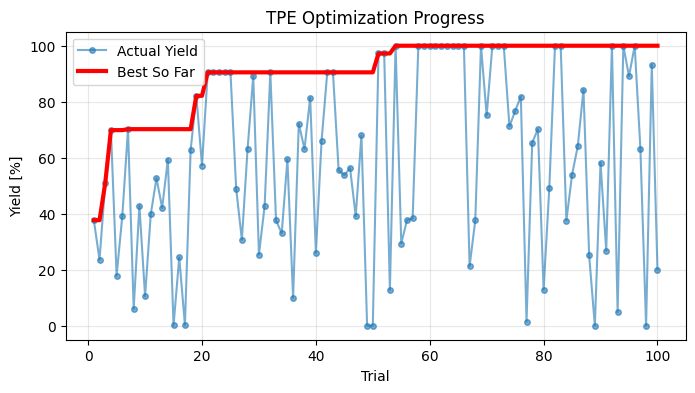

最適化履歴を ../runs/optuna_tpe_100trials_NiB/visualization/optimization_progress.png に保存しました


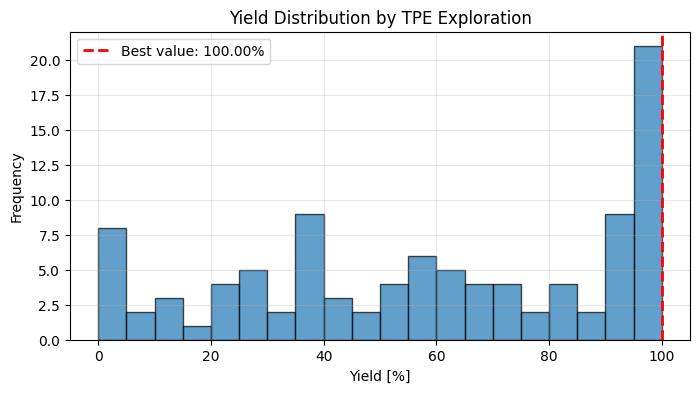

収率分布を ../runs/optuna_tpe_100trials_NiB/visualization/yield_distribution.png に保存しました


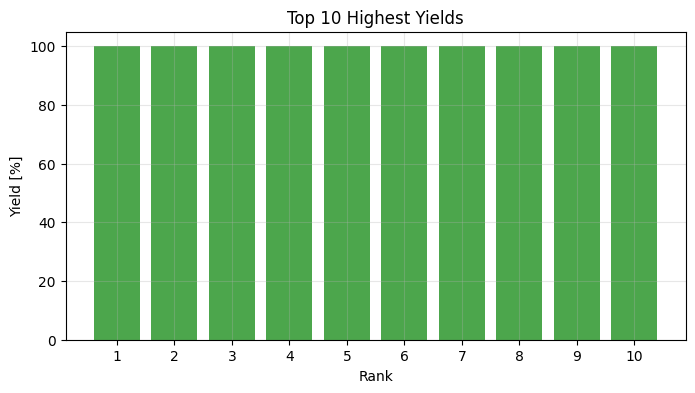

Top 10収率を ../runs/optuna_tpe_100trials_NiB/visualization/top10_yields.png に保存しました


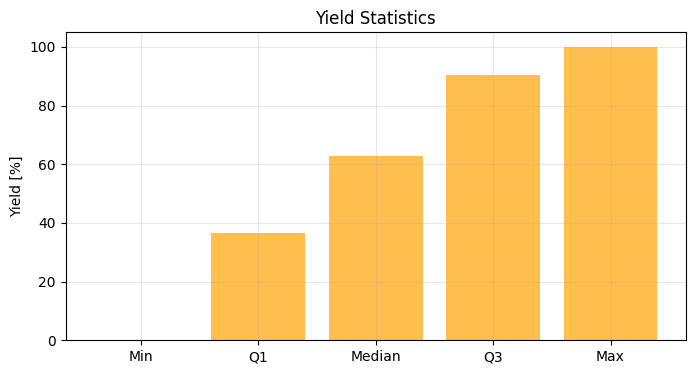

収率統計を ../runs/optuna_tpe_100trials_NiB/visualization/yield_statistics.png に保存しました


In [9]:
plt.style.use('default')

# 1. 最適化履歴
fig = plt.figure(figsize=(8, 4))
plt.plot(range(1, len(trial_values)+1), trial_values, 'o-', alpha=0.6, label='Actual Yield', markersize=4)
plt.plot(range(1, len(trial_values)+1), best_values, 'r-', linewidth=3, label='Best So Far')
plt.xlabel('Trial')
plt.ylabel('Yield [%]')
plt.title('TPE Optimization Progress')
plt.legend()
plt.grid(True, alpha=0.3)
fig.savefig(f"{viz_dir}/optimization_progress.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print(f"最適化履歴を {viz_dir}/optimization_progress.png に保存しました")

# 2. 収率分布
fig = plt.figure(figsize=(8, 4))
plt.hist(trial_values, bins=20, alpha=0.7, edgecolor='black')
plt.axvline(study.best_value, color='red', linestyle='--', linewidth=2, label=f'Best value: {study.best_value:.2f}%')
plt.xlabel('Yield [%]')
plt.ylabel('Frequency')
plt.title('Yield Distribution by TPE Exploration')
plt.legend()
plt.grid(True, alpha=0.3)
fig.savefig(f"{viz_dir}/yield_distribution.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print(f"収率分布を {viz_dir}/yield_distribution.png に保存しました")

# 3. Top 10 収率
top_trials = sorted(study.trials, key=lambda t: t.value, reverse=True)[:10]
top_values = [t.value for t in top_trials]
top_indices = list(range(1, 11))

fig = plt.figure(figsize=(8, 4))
plt.bar(top_indices, top_values, alpha=0.7, color='green')
plt.xlabel('Rank')
plt.ylabel('Yield [%]')
plt.title('Top 10 Highest Yields')
plt.xticks(top_indices)
plt.grid(True, alpha=0.3)
fig.savefig(f"{viz_dir}/top10_yields.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print(f"Top 10収率を {viz_dir}/top10_yields.png に保存しました")

# 4. 収率の統計情報
stats_data = [np.min(trial_values), np.percentile(trial_values, 25), 
              np.median(trial_values), np.percentile(trial_values, 75), np.max(trial_values)]
stats_labels = ['Min', 'Q1', 'Median', 'Q3', 'Max']

fig = plt.figure(figsize=(8, 4))
plt.bar(stats_labels, stats_data, alpha=0.7, color='orange')
plt.ylabel('Yield [%]')
plt.title('Yield Statistics')
plt.grid(True, alpha=0.3)
fig.savefig(f"{viz_dir}/yield_statistics.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print(f"収率統計を {viz_dir}/yield_statistics.png に保存しました")

## GPSampler

In [10]:
def run_gp_optimization(
    n_trials: int = 100,
    seed: int = 42,
    db_path: str = "../runs/optuna_gp_100trials_NiB/optuna_gp_100trials_NiB.db",
    *,
    n_startup_trials: int = 10,
    deterministic_objective: bool = False,
):
    """
    反応収率最大化のためのGaussian Process( GP )最適化を実行（Optuna GPSampler）

    Args:
        n_trials (int): 最適化試行回数
        seed (int): 再現性のためのランダムシード
        db_path (str): 結果保存用SQLiteデータベースのパス
        n_startup_trials (int): 初期のランダム探索回数（既知データが少ない序盤を安定化）
        deterministic_objective (bool): 目的関数が決定的なら True（ノイズを想定しない学習）

    Returns:
        optuna.Study: 完了した最適化スタディ
    """

    # 出力ディレクトリの作成
    os.makedirs(os.path.dirname(db_path), exist_ok=True)

    # GPサンプラーを設定
    sampler = GPSampler(
        seed=seed,
        n_startup_trials=n_startup_trials,
        deterministic_objective=deterministic_objective,
    )

    # 新規スタディの作成または既存スタディの読み込み
    study = optuna.create_study(
        direction="maximize",                     # 収率を最大化
        sampler=sampler,                          # GPサンプラーを使用
        study_name="gp_yield_optimization_NiB",
        storage=f"sqlite:///{db_path}",           # 永続化ストレージ
        load_if_exists=True,                      # 既存DBがあれば再利用
    )

    # 最適化の実行
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    # 最適化結果の表示
    print("最適化完了")
    print(f"最良の収率: {study.best_value:.2f}%")
    print("最適な反応条件:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    print(f"最適化結果の保存先: {db_path}")
    return study


In [11]:
 study = run_gp_optimization(n_trials=100, seed=42)

[I 2025-09-25 06:19:01,733] A new study created in RDB with name: gp_yield_optimization_NiB
Best trial: 0. Best value: 37.6993:   2%|▏         | 2/100 [00:00<00:14,  6.79it/s]

[I 2025-09-25 06:19:01,879] Trial 0 finished with value: 37.699250000000006 and parameters: {'electrophile_inchi': 'InChI=1S/C9H12BrNO2/c1-3-11-6-7(10)5-8(11)9(12)13-4-2/h5-6H,3-4H2,1-2H3', 'ligand_inchi': 'InChI=1S/C18H12F3P/c19-13-1-7-16(8-2-13)22(17-9-3-14(20)4-10-17)18-11-5-15(21)6-12-18/h1-12H', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 0 with value: 37.699250000000006.
[I 2025-09-25 06:19:02,023] Trial 1 finished with value: 23.52475 and parameters: {'electrophile_inchi': 'InChI=1S/C9H12BrNO2/c1-3-11-6-7(10)5-8(11)9(12)13-4-2/h5-6H,3-4H2,1-2H3', 'ligand_inchi': 'InChI=1S/C24H27P/c1-16-7-17(2)11-22(10-16)25(23-12-18(3)8-19(4)13-23)24-14-20(5)9-21(6)15-24/h7-15H,1-6H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 0 with value: 37.699250000000006.


Best trial: 3. Best value: 69.855:   4%|▍         | 4/100 [00:00<00:14,  6.79it/s] 

[I 2025-09-25 06:19:02,164] Trial 2 finished with value: 50.93 and parameters: {'electrophile_inchi': 'InChI=1S/C7H6ClFO/c1-10-7-4-5(8)2-3-6(7)9/h2-4H,1H3', 'ligand_inchi': 'InChI=1S/C30H34NP/c1-3-13-23(14-4-1)32(24-15-5-2-6-16-24)30-22-12-11-21-29(30)31-27-19-9-7-17-25(27)26-18-8-10-20-28(26)31/h7-12,17-24H,1-6,13-16H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 2 with value: 50.93.
[I 2025-09-25 06:19:02,316] Trial 3 finished with value: 69.855 and parameters: {'electrophile_inchi': 'InChI=1S/C10H12N2O3S2/c1-7-11-9-6-8(4-5-10(9)16-7)15-17(13,14)12(2)3/h4-6H,1-3H3', 'ligand_inchi': 'InChI=1S/C18H15P/c1-4-10-16(11-5-1)19(17-12-6-2-7-13-17)18-14-8-3-9-15-18/h1-15H', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 3 with value: 69.855.


Best trial: 3. Best value: 69.855:   6%|▌         | 6/100 [00:00<00:13,  7.00it/s]

[I 2025-09-25 06:19:02,456] Trial 4 finished with value: 17.87 and parameters: {'electrophile_inchi': 'InChI=1S/C7H6ClFO/c1-10-7-3-2-5(8)4-6(7)9/h2-4H,1H3', 'ligand_inchi': 'InChI=1S/C35H39OP/c1-36-31-23-13-12-22-30(31)34-32-26-18-8-10-20-28(26)33(29-21-11-9-19-27(29)32)35(34)37(24-14-4-2-5-15-24)25-16-6-3-7-17-25/h8-13,18-25,32-33H,2-7,14-17H2,1H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 3 with value: 69.855.
[I 2025-09-25 06:19:02,595] Trial 5 finished with value: 39.19 and parameters: {'electrophile_inchi': 'InChI=1S/C9H6BrN/c10-8-5-7-3-1-2-4-9(7)11-6-8/h1-6H', 'ligand_inchi': 'InChI=1S/C29H39P.BF4/c1-2-3-22-29(27-20-12-10-18-25(27)26-19-11-13-21-28(26)29)30(23-14-6-4-7-15-23)24-16-8-5-9-17-24;2-1(3,4)5/h10-13,18-21,23-24H,2-9,14-17,22H2,1H3;/q;-1/p+1', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 3 with value: 69.855.


Best trial: 6. Best value: 70.2032:   8%|▊         | 8/100 [00:01<00:13,  7.05it/s]

[I 2025-09-25 06:19:02,736] Trial 6 finished with value: 70.20319063751154 and parameters: {'electrophile_inchi': 'InChI=1S/C7H6BrFO/c1-10-7-3-2-5(8)4-6(7)9/h2-4H,1H3', 'ligand_inchi': 'InChI=1S/C25H33P/c1-20-12-8-9-17-23(20)24-18-10-11-19-25(24)26(21-13-4-2-5-14-21)22-15-6-3-7-16-22/h8-12,17-19,21-22H,2-7,13-16H2,1H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 6 with value: 70.20319063751154.
[I 2025-09-25 06:19:02,876] Trial 7 finished with value: 6.03 and parameters: {'electrophile_inchi': 'InChI=1S/C7H8ClN/c1-5-6(8)3-2-4-7(5)9/h2-4H,9H2,1H3', 'ligand_inchi': 'InChI=1S/C22H30NP/c1-4-11-19(12-5-1)23-18-10-17-22(23)24(20-13-6-2-7-14-20)21-15-8-3-9-16-21/h1,4-5,10-12,17-18,20-21H,2-3,6-9,13-16H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 6 with value: 70.20319063751154.


Best trial: 6. Best value: 70.2032:  10%|█         | 10/100 [00:01<00:13,  6.85it/s]

[I 2025-09-25 06:19:03,027] Trial 8 finished with value: 42.93 and parameters: {'electrophile_inchi': 'InChI=1S/C9H12BrNO2/c1-3-11-6-7(10)5-8(11)9(12)13-4-2/h5-6H,3-4H2,1-2H3', 'ligand_inchi': 'InChI=1S/C24H27P/c1-16-7-17(2)11-22(10-16)25(23-12-18(3)8-19(4)13-23)24-14-20(5)9-21(6)15-24/h7-15H,1-6H3', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 6 with value: 70.20319063751154.
[I 2025-09-25 06:19:03,176] Trial 9 finished with value: 10.525 and parameters: {'electrophile_inchi': 'InChI=1S/C9H10ClNO/c1-11(2)9(12)7-3-5-8(10)6-4-7/h3-6H,1-2H3', 'ligand_inchi': 'InChI=1S/C14H23P/c1-13(2,3)15(14(4,5)6)12-10-8-7-9-11-12/h7-11H,1-6H3', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 6 with value: 70.20319063751154.


Best trial: 6. Best value: 70.2032:  12%|█▏        | 12/100 [00:03<00:47,  1.87it/s]

[I 2025-09-25 06:19:05,093] Trial 10 finished with value: 50.46526639975362 and parameters: {'electrophile_inchi': 'InChI=1S/C7H6BrFO/c1-10-7-3-2-5(8)4-6(7)9/h2-4H,1H3', 'ligand_inchi': 'InChI=1S/C18H15P/c1-4-10-16(11-5-1)19(17-12-6-2-7-13-17)18-14-8-3-9-15-18/h1-15H', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 6 with value: 70.20319063751154.
[I 2025-09-25 06:19:05,280] Trial 11 finished with value: 6.715 and parameters: {'electrophile_inchi': 'InChI=1S/C10H12N2O3S2/c1-7-11-9-6-8(4-5-10(9)16-7)15-17(13,14)12(2)3/h4-6H,1-3H3', 'ligand_inchi': 'InChI=1S/C25H33P/c1-20-12-8-9-17-23(20)24-18-10-11-19-25(24)26(21-13-4-2-5-14-21)22-15-6-3-7-16-22/h8-12,17-19,21-22H,2-7,13-16H2,1H3', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 6 with value: 70.20319063751154.


Best trial: 6. Best value: 70.2032:  14%|█▍        | 14/100 [00:03<00:30,  2.82it/s]

[I 2025-09-25 06:19:05,482] Trial 12 finished with value: 52.69 and parameters: {'electrophile_inchi': 'InChI=1S/C10H12N2O3S2/c1-7-11-9-6-8(4-5-10(9)16-7)15-17(13,14)12(2)3/h4-6H,1-3H3', 'ligand_inchi': 'InChI=1S/C18H15P/c1-4-10-16(11-5-1)19(17-12-6-2-7-13-17)18-14-8-3-9-15-18/h1-15H', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 6 with value: 70.20319063751154.
[I 2025-09-25 06:19:05,653] Trial 13 finished with value: 40.93394518016631 and parameters: {'electrophile_inchi': 'InChI=1S/C7H6BrFO/c1-10-7-3-2-5(8)4-6(7)9/h2-4H,1H3', 'ligand_inchi': 'InChI=1S/C25H33P/c1-20-12-8-9-17-23(20)24-18-10-11-19-25(24)26(21-13-4-2-5-14-21)22-15-6-3-7-16-22/h8-12,17-19,21-22H,2-7,13-16H2,1H3', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 6 with value: 70.20319063751154.


Best trial: 15. Best value: 98.5439:  16%|█▌        | 16/100 [00:04<00:22,  3.74it/s]

[I 2025-09-25 06:19:05,847] Trial 14 finished with value: 27.36 and parameters: {'electrophile_inchi': 'InChI=1S/C7H6ClFO/c1-10-7-4-5(8)2-3-6(7)9/h2-4H,1H3', 'ligand_inchi': 'InChI=1S/C18H15P/c1-4-10-16(11-5-1)19(17-12-6-2-7-13-17)18-14-8-3-9-15-18/h1-15H', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 6 with value: 70.20319063751154.
[I 2025-09-25 06:19:06,024] Trial 15 finished with value: 98.54392362180474 and parameters: {'electrophile_inchi': 'InChI=1S/C7H6BrFO/c1-10-7-3-2-5(8)4-6(7)9/h2-4H,1H3', 'ligand_inchi': 'InChI=1S/C30H34NP/c1-3-13-23(14-4-1)32(24-15-5-2-6-16-24)30-22-12-11-21-29(30)31-27-19-9-7-17-25(27)26-18-8-10-20-28(26)31/h7-12,17-24H,1-6,13-16H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 15 with value: 98.54392362180474.


Best trial: 15. Best value: 98.5439:  18%|█▊        | 18/100 [00:04<00:18,  4.39it/s]

[I 2025-09-25 06:19:06,217] Trial 16 finished with value: 71.13170311056359 and parameters: {'electrophile_inchi': 'InChI=1S/C7H6BrFO/c1-10-7-3-2-5(8)4-6(7)9/h2-4H,1H3', 'ligand_inchi': 'InChI=1S/C30H34NP/c1-3-13-23(14-4-1)32(24-15-5-2-6-16-24)30-22-12-11-21-29(30)31-27-19-9-7-17-25(27)26-18-8-10-20-28(26)31/h7-12,17-24H,1-6,13-16H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 15 with value: 98.54392362180474.
[I 2025-09-25 06:19:06,406] Trial 17 finished with value: 98.54392362180474 and parameters: {'electrophile_inchi': 'InChI=1S/C7H6BrFO/c1-10-7-3-2-5(8)4-6(7)9/h2-4H,1H3', 'ligand_inchi': 'InChI=1S/C30H34NP/c1-3-13-23(14-4-1)32(24-15-5-2-6-16-24)30-22-12-11-21-29(30)31-27-19-9-7-17-25(27)26-18-8-10-20-28(26)31/h7-12,17-24H,1-6,13-16H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 15 with value: 98.54392362180474.


Best trial: 15. Best value: 98.5439:  20%|██        | 20/100 [00:05<00:16,  4.77it/s]

[I 2025-09-25 06:19:06,608] Trial 18 finished with value: 77.75790575916231 and parameters: {'electrophile_inchi': 'InChI=1S/C7H6BrFO/c1-10-7-3-2-5(8)4-6(7)9/h2-4H,1H3', 'ligand_inchi': 'InChI=1S/C26H32NP/c1-4-12-21(13-5-1)26-20-22-14-10-11-19-25(22)27(26)28(23-15-6-2-7-16-23)24-17-8-3-9-18-24/h1,4-5,10-14,19-20,23-24H,2-3,6-9,15-18H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 15 with value: 98.54392362180474.
[I 2025-09-25 06:19:06,793] Trial 19 finished with value: 61.410458885124726 and parameters: {'electrophile_inchi': 'InChI=1S/C7H6BrFO/c1-10-7-3-2-5(8)4-6(7)9/h2-4H,1H3', 'ligand_inchi': 'InChI=1S/C21H21O3P/c1-22-16-10-4-7-13-19(16)25(20-14-8-5-11-17(20)23-2)21-15-9-6-12-18(21)24-3/h4-15H,1-3H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 15 with value: 98.54392362180474.


Best trial: 15. Best value: 98.5439:  21%|██        | 21/100 [00:05<00:15,  4.97it/s]

[I 2025-09-25 06:19:06,975] Trial 20 finished with value: 39.773304588851246 and parameters: {'electrophile_inchi': 'InChI=1S/C7H6BrFO/c1-10-7-3-2-5(8)4-6(7)9/h2-4H,1H3', 'ligand_inchi': 'InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17)22(18-9-5-3-6-10-18)19-11-7-4-8-12-19/h3-16H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 15 with value: 98.54392362180474.


Best trial: 15. Best value: 98.5439:  22%|██▏       | 22/100 [00:05<00:19,  3.94it/s]

[I 2025-09-25 06:19:07,349] Trial 21 finished with value: 95.71618109023716 and parameters: {'electrophile_inchi': 'InChI=1S/C7H6BrFO/c1-10-7-3-2-5(8)4-6(7)9/h2-4H,1H3', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 15 with value: 98.54392362180474.


Best trial: 23. Best value: 100:  24%|██▍       | 24/100 [00:06<00:17,  4.34it/s]    

[I 2025-09-25 06:19:07,589] Trial 22 finished with value: 44.33145672928858 and parameters: {'electrophile_inchi': 'InChI=1S/C7H6BrFO/c1-10-7-3-2-5(8)4-6(7)9/h2-4H,1H3', 'ligand_inchi': 'InChI=1S/C33H49OP/c1-32(2,3)24-22-28(33(4,5)6)31(29(23-24)34-7)27-20-14-15-21-30(27)35(25-16-10-8-11-17-25)26-18-12-9-13-19-26/h14-15,20-23,25-26H,8-13,16-19H2,1-7H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 15 with value: 98.54392362180474.
[I 2025-09-25 06:19:07,777] Trial 23 finished with value: 100.0 and parameters: {'electrophile_inchi': 'InChI=1S/C7H6BrFO/c1-10-7-3-2-5(8)4-6(7)9/h2-4H,1H3', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  26%|██▌       | 26/100 [00:06<00:17,  4.12it/s]

[I 2025-09-25 06:19:08,124] Trial 24 finished with value: 36.17883584847552 and parameters: {'electrophile_inchi': 'InChI=1S/C7H6BrFO/c1-10-7-3-2-5(8)4-6(7)9/h2-4H,1H3', 'ligand_inchi': 'InChI=1S/C21H21O3P/c1-22-16-4-10-19(11-5-16)25(20-12-6-17(23-2)7-13-20)21-14-8-18(24-3)9-15-21/h4-15H,1-3H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.
[I 2025-09-25 06:19:08,314] Trial 25 finished with value: 94.1805964715766 and parameters: {'electrophile_inchi': 'InChI=1S/C12H9Br/c13-12-8-6-11(7-9-12)10-4-2-1-3-5-10/h1-9H', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  27%|██▋       | 27/100 [00:06<00:16,  4.43it/s]

[I 2025-09-25 06:19:08,501] Trial 26 finished with value: 94.77821198543823 and parameters: {'electrophile_inchi': 'InChI=1S/C12H9Br/c13-12-8-6-11(7-9-12)10-4-2-1-3-5-10/h1-9H', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  28%|██▊       | 28/100 [00:07<00:21,  3.35it/s]

[I 2025-09-25 06:19:08,969] Trial 27 finished with value: 84.4 and parameters: {'electrophile_inchi': 'InChI=1S/C7H3ClFN/c8-6-2-1-5(4-10)7(9)3-6/h1-3H', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 23 with value: 100.0.
[I 2025-09-25 06:19:09,163] Trial 28 finished with value: 69.34 and parameters: {'electrophile_inchi': 'InChI=1S/C7H5ClO2/c8-5-1-2-6-7(3-5)10-4-9-6/h1-3H,4H2', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  30%|███       | 30/100 [00:07<00:16,  4.12it/s]

[I 2025-09-25 06:19:09,347] Trial 29 finished with value: 52.32 and parameters: {'electrophile_inchi': 'InChI=1S/C7H3BrFN/c8-6-2-1-5(4-10)7(9)3-6/h1-3H', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  32%|███▏      | 32/100 [00:08<00:23,  2.91it/s]

[I 2025-09-25 06:19:10,146] Trial 30 finished with value: 89.09596611593389 and parameters: {'electrophile_inchi': 'InChI=1S/C12H9Br/c13-12-8-6-11(7-9-12)10-4-2-1-3-5-10/h1-9H', 'ligand_inchi': 'InChI=1S/C30H34NP/c1-3-13-23(14-4-1)32(24-15-5-2-6-16-24)30-22-12-11-21-29(30)31-27-19-9-7-17-25(27)26-18-8-10-20-28(26)31/h7-12,17-24H,1-6,13-16H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.
[I 2025-09-25 06:19:10,330] Trial 31 finished with value: 57.26 and parameters: {'electrophile_inchi': 'InChI=1S/C7H3ClFN/c8-6-2-1-5(4-10)7(9)3-6/h1-3H', 'ligand_inchi': 'InChI=1S/C30H34NP/c1-3-13-23(14-4-1)32(24-15-5-2-6-16-24)30-22-12-11-21-29(30)31-27-19-9-7-17-25(27)26-18-8-10-20-28(26)31/h7-12,17-24H,1-6,13-16H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  33%|███▎      | 33/100 [00:08<00:20,  3.34it/s]

[I 2025-09-25 06:19:10,534] Trial 32 finished with value: 73.75 and parameters: {'electrophile_inchi': 'InChI=1S/C7H4ClF3/c8-6-3-1-5(2-4-6)7(9,10)11/h1-4H', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  35%|███▌      | 35/100 [00:09<00:21,  3.04it/s]

[I 2025-09-25 06:19:11,129] Trial 33 finished with value: 51.2 and parameters: {'electrophile_inchi': 'InChI=1S/C11H12N2O3S/c1-13(2)17(14,15)16-10-5-6-11-9(8-10)4-3-7-12-11/h3-8H,1-2H3', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 23 with value: 100.0.
[I 2025-09-25 06:19:11,318] Trial 34 finished with value: 80.44 and parameters: {'electrophile_inchi': 'InChI=1S/C10H12N2O3S/c1-12(2)16(13,14)15-9-3-4-10-8(7-9)5-6-11-10/h3-7,11H,1-2H3', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  36%|███▌      | 36/100 [00:09<00:18,  3.44it/s]

[I 2025-09-25 06:19:11,519] Trial 35 finished with value: 87.16353978 and parameters: {'electrophile_inchi': 'InChI=1S/C6H6BrN/c1-5-6(7)3-2-4-8-5/h2-4H,1H3', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  37%|███▋      | 37/100 [00:10<00:26,  2.35it/s]

[I 2025-09-25 06:19:12,259] Trial 36 finished with value: 45.43 and parameters: {'electrophile_inchi': 'InChI=1S/C12H9Br/c13-12-9-5-4-8-11(12)10-6-2-1-3-7-10/h1-9H', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  38%|███▊      | 38/100 [00:10<00:22,  2.78it/s]

[I 2025-09-25 06:19:12,467] Trial 37 finished with value: 55.57791165 and parameters: {'electrophile_inchi': 'InChI=1S/C6H6BrN/c1-5-6(7)3-2-4-8-5/h2-4H,1H3', 'ligand_inchi': 'InChI=1S/C30H34NP/c1-3-13-23(14-4-1)32(24-15-5-2-6-16-24)30-22-12-11-21-29(30)31-27-19-9-7-17-25(27)26-18-8-10-20-28(26)31/h7-12,17-24H,1-6,13-16H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.
[I 2025-09-25 06:19:12,664] Trial 38 finished with value: 85.59 and parameters: {'electrophile_inchi': 'InChI=1S/C7H7BrO/c1-9-7-4-2-6(8)3-5-7/h2-5H,1H3', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  40%|████      | 40/100 [00:11<00:24,  2.45it/s]

[I 2025-09-25 06:19:13,299] Trial 39 finished with value: 34.55 and parameters: {'electrophile_inchi': 'InChI=1S/C9H8ClFO2/c1-2-13-9(12)6-3-4-7(10)8(11)5-6/h3-5H,2H2,1H3', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  41%|████      | 41/100 [00:11<00:20,  2.87it/s]

[I 2025-09-25 06:19:13,506] Trial 40 finished with value: 87.80276533183982 and parameters: {'electrophile_inchi': 'InChI=1S/C12H9Br/c13-12-8-6-11(7-9-12)10-4-2-1-3-5-10/h1-9H', 'ligand_inchi': 'InChI=1S/C26H32NP/c1-4-12-21(13-5-1)26-20-22-14-10-11-19-25(22)27(26)28(23-15-6-2-7-16-23)24-17-8-3-9-18-24/h1,4-5,10-14,19-20,23-24H,2-3,6-9,15-18H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  42%|████▏     | 42/100 [00:11<00:17,  3.28it/s]

[I 2025-09-25 06:19:13,709] Trial 41 finished with value: 80.58239428731447 and parameters: {'electrophile_inchi': 'InChI=1S/C12H9Br/c13-12-8-6-11(7-9-12)10-4-2-1-3-5-10/h1-9H', 'ligand_inchi': 'InChI=1S/C26H32NP/c1-4-12-21(13-5-1)26-20-22-14-10-11-19-25(22)27(26)28(23-15-6-2-7-16-23)24-17-8-3-9-18-24/h1,4-5,10-14,19-20,23-24H,2-3,6-9,15-18H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 23 with value: 100.0.


[I 2025-09-25 06:19:14,194] Trial 42 finished with value: 42.335001400168025 and parameters: {'electrophile_inchi': 'InChI=1S/C12H9Br/c13-12-8-6-11(7-9-12)10-4-2-1-3-5-10/h1-9H', 'ligand_inchi': 'InChI=1S/C3H9P.BF4/c1-4(2)3;2-1(3,4)5/h1-3H3;/q;-1/p+1', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.
[I 2025-09-25 06:19:14,394] Trial 43 finished with value: 41.010000000000005 and parameters: {'electrophile_inchi': 'InChI=1S/C7H6ClF/c1-5-4-6(9)2-3-7(5)8/h2-4H,1H3', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  45%|████▌     | 45/100 [00:12<00:15,  3.62it/s]

[I 2025-09-25 06:19:14,591] Trial 44 finished with value: 88.245 and parameters: {'electrophile_inchi': 'InChI=1S/C7H7BrO/c1-9-7-4-2-6(8)3-5-7/h2-5H,1H3', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  46%|████▌     | 46/100 [00:13<00:19,  2.82it/s]

[I 2025-09-25 06:19:15,126] Trial 45 finished with value: 84.445 and parameters: {'electrophile_inchi': 'InChI=1S/C7H7BrO/c1-9-7-4-2-6(8)3-5-7/h2-5H,1H3', 'ligand_inchi': 'InChI=1S/C26H32NP/c1-4-12-21(13-5-1)26-20-22-14-10-11-19-25(22)27(26)28(23-15-6-2-7-16-23)24-17-8-3-9-18-24/h1,4-5,10-14,19-20,23-24H,2-3,6-9,15-18H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  47%|████▋     | 47/100 [00:13<00:16,  3.19it/s]

[I 2025-09-25 06:19:15,345] Trial 46 finished with value: 96.055 and parameters: {'electrophile_inchi': 'InChI=1S/C7H7BrO/c1-9-7-4-2-6(8)3-5-7/h2-5H,1H3', 'ligand_inchi': 'InChI=1S/C30H34NP/c1-3-13-23(14-4-1)32(24-15-5-2-6-16-24)30-22-12-11-21-29(30)31-27-19-9-7-17-25(27)26-18-8-10-20-28(26)31/h7-12,17-24H,1-6,13-16H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  48%|████▊     | 48/100 [00:13<00:14,  3.49it/s]

[I 2025-09-25 06:19:15,566] Trial 47 finished with value: 76.65 and parameters: {'electrophile_inchi': 'InChI=1S/C10H12N2O3S/c1-12(2)16(13,14)15-9-3-4-10-8(7-9)5-6-11-10/h3-7,11H,1-2H3', 'ligand_inchi': 'InChI=1S/C30H34NP/c1-3-13-23(14-4-1)32(24-15-5-2-6-16-24)30-22-12-11-21-29(30)31-27-19-9-7-17-25(27)26-18-8-10-20-28(26)31/h7-12,17-24H,1-6,13-16H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  49%|████▉     | 49/100 [00:14<00:19,  2.56it/s]

[I 2025-09-25 06:19:16,192] Trial 48 finished with value: 81.83 and parameters: {'electrophile_inchi': 'InChI=1S/C10H12N2O3S/c1-12(2)16(13,14)15-9-3-4-10-8(7-9)5-6-11-10/h3-7,11H,1-2H3', 'ligand_inchi': 'InChI=1S/C26H32NP/c1-4-12-21(13-5-1)26-20-22-14-10-11-19-25(22)27(26)28(23-15-6-2-7-16-23)24-17-8-3-9-18-24/h1,4-5,10-14,19-20,23-24H,2-3,6-9,15-18H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  50%|█████     | 50/100 [00:14<00:17,  2.93it/s]

[I 2025-09-25 06:19:16,427] Trial 49 finished with value: 72.11 and parameters: {'electrophile_inchi': 'InChI=1S/C7H4ClF3/c8-6-3-1-5(2-4-6)7(9,10)11/h1-4H', 'ligand_inchi': 'InChI=1S/C26H32NP/c1-4-12-21(13-5-1)26-20-22-14-10-11-19-25(22)27(26)28(23-15-6-2-7-16-23)24-17-8-3-9-18-24/h1,4-5,10-14,19-20,23-24H,2-3,6-9,15-18H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.
[I 2025-09-25 06:19:16,624] Trial 50 finished with value: 58.22 and parameters: {'electrophile_inchi': 'InChI=1S/C7H7BrO/c1-9-7-4-2-6(8)3-5-7/h2-5H,1H3', 'ligand_inchi': 'InChI=1S/C26H23O2P/c1-27-23-17-11-18-24(28-2)26(23)22-16-9-10-19-25(22)29(20-12-5-3-6-13-20)21-14-7-4-8-15-21/h3-19H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  52%|█████▏    | 52/100 [00:15<00:17,  2.78it/s]

[I 2025-09-25 06:19:17,126] Trial 51 finished with value: 68.195 and parameters: {'electrophile_inchi': 'InChI=1S/C8H7BrO2/c1-11-8(10)6-2-4-7(9)5-3-6/h2-5H,1H3', 'ligand_inchi': 'InChI=1S/C30H34NP/c1-3-13-23(14-4-1)32(24-15-5-2-6-16-24)30-22-12-11-21-29(30)31-27-19-9-7-17-25(27)26-18-8-10-20-28(26)31/h7-12,17-24H,1-6,13-16H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.
[I 2025-09-25 06:19:17,321] Trial 52 finished with value: 1.07 and parameters: {'electrophile_inchi': 'InChI=1S/C8H9Cl/c1-6-4-3-5-7(2)8(6)9/h3-5H,1-2H3', 'ligand_inchi': 'InChI=1S/C26H32NP/c1-4-12-21(13-5-1)26-20-22-14-10-11-19-25(22)27(26)28(23-15-6-2-7-16-23)24-17-8-3-9-18-24/h1,4-5,10-14,19-20,23-24H,2-3,6-9,15-18H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  54%|█████▍    | 54/100 [00:15<00:15,  3.02it/s]

[I 2025-09-25 06:19:17,702] Trial 53 finished with value: 73.35499999999999 and parameters: {'electrophile_inchi': 'InChI=1S/C7H7BrO/c1-9-7-4-2-6(8)3-5-7/h2-5H,1H3', 'ligand_inchi': 'InChI=1S/C30H34NP/c1-3-13-23(14-4-1)32(24-15-5-2-6-16-24)30-22-12-11-21-29(30)31-27-19-9-7-17-25(27)26-18-8-10-20-28(26)31/h7-12,17-24H,1-6,13-16H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  55%|█████▌    | 55/100 [00:17<00:27,  1.63it/s]

[I 2025-09-25 06:19:18,977] Trial 54 finished with value: 69.35 and parameters: {'electrophile_inchi': 'InChI=1S/C7H4ClF3/c8-6-3-1-5(2-4-6)7(9,10)11/h1-4H', 'ligand_inchi': 'InChI=1S/C30H34NP/c1-3-13-23(14-4-1)32(24-15-5-2-6-16-24)30-22-12-11-21-29(30)31-27-19-9-7-17-25(27)26-18-8-10-20-28(26)31/h7-12,17-24H,1-6,13-16H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  56%|█████▌    | 56/100 [00:17<00:22,  1.95it/s]

[I 2025-09-25 06:19:19,250] Trial 55 finished with value: 66.06 and parameters: {'electrophile_inchi': 'InChI=1S/C7H4BrF3/c8-6-3-1-5(2-4-6)7(9,10)11/h1-4H', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  57%|█████▋    | 57/100 [00:17<00:19,  2.23it/s]

[I 2025-09-25 06:19:19,551] Trial 56 finished with value: 57.28 and parameters: {'electrophile_inchi': 'InChI=1S/C8H7ClO2/c1-11-8(10)6-2-4-7(9)5-3-6/h2-5H,1H3', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  58%|█████▊    | 58/100 [00:19<00:28,  1.48it/s]

[I 2025-09-25 06:19:20,756] Trial 57 finished with value: 84.28999999999999 and parameters: {'electrophile_inchi': 'InChI=1S/C7H7BrO/c1-9-7-4-2-6(8)3-5-7/h2-5H,1H3', 'ligand_inchi': 'InChI=1S/C36H39N4P/c1-6-16-28(17-7-1)34-36(35(29-18-8-2-9-19-29)39(38-34)30-20-10-3-11-21-30)40-33(26-27-37-40)41(31-22-12-4-13-23-31)32-24-14-5-15-25-32/h1-3,6-11,16-21,26-27,31-32H,4-5,12-15,22-25H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  59%|█████▉    | 59/100 [00:19<00:22,  1.80it/s]

[I 2025-09-25 06:19:21,034] Trial 58 finished with value: 94.39612993559228 and parameters: {'electrophile_inchi': 'InChI=1S/C12H9Br/c13-12-8-6-11(7-9-12)10-4-2-1-3-5-10/h1-9H', 'ligand_inchi': 'InChI=1S/C36H39N4P/c1-6-16-28(17-7-1)34-36(35(29-18-8-2-9-19-29)39(38-34)30-20-10-3-11-21-30)40-33(26-27-37-40)41(31-22-12-4-13-23-31)32-24-14-5-15-25-32/h1-3,6-11,16-21,26-27,31-32H,4-5,12-15,22-25H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  60%|██████    | 60/100 [00:19<00:18,  2.15it/s]

[I 2025-09-25 06:19:21,290] Trial 59 finished with value: 86.30382805936712 and parameters: {'electrophile_inchi': 'InChI=1S/C12H9Br/c13-12-8-6-11(7-9-12)10-4-2-1-3-5-10/h1-9H', 'ligand_inchi': 'InChI=1S/C36H39N4P/c1-6-16-28(17-7-1)34-36(35(29-18-8-2-9-19-29)39(38-34)30-20-10-3-11-21-30)40-33(26-27-37-40)41(31-22-12-4-13-23-31)32-24-14-5-15-25-32/h1-3,6-11,16-21,26-27,31-32H,4-5,12-15,22-25H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  61%|██████    | 61/100 [00:20<00:23,  1.66it/s]

[I 2025-09-25 06:19:22,210] Trial 60 finished with value: 93.3667631659994 and parameters: {'electrophile_inchi': 'InChI=1S/C7H6BrFO/c1-10-7-3-2-5(8)4-6(7)9/h2-4H,1H3', 'ligand_inchi': 'InChI=1S/C36H39N4P/c1-6-16-28(17-7-1)34-36(35(29-18-8-2-9-19-29)39(38-34)30-20-10-3-11-21-30)40-33(26-27-37-40)41(31-22-12-4-13-23-31)32-24-14-5-15-25-32/h1-3,6-11,16-21,26-27,31-32H,4-5,12-15,22-25H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  62%|██████▏   | 62/100 [00:20<00:18,  2.02it/s]

[I 2025-09-25 06:19:22,456] Trial 61 finished with value: 82.92 and parameters: {'electrophile_inchi': 'InChI=1S/C10H12N2O3S/c1-12(2)16(13,14)15-9-3-4-10-8(7-9)5-6-11-10/h3-7,11H,1-2H3', 'ligand_inchi': 'InChI=1S/C36H39N4P/c1-6-16-28(17-7-1)34-36(35(29-18-8-2-9-19-29)39(38-34)30-20-10-3-11-21-30)40-33(26-27-37-40)41(31-22-12-4-13-23-31)32-24-14-5-15-25-32/h1-3,6-11,16-21,26-27,31-32H,4-5,12-15,22-25H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  63%|██████▎   | 63/100 [00:21<00:15,  2.33it/s]

[I 2025-09-25 06:19:22,732] Trial 62 finished with value: 63.23195043405209 and parameters: {'electrophile_inchi': 'InChI=1S/C12H9Br/c13-12-8-6-11(7-9-12)10-4-2-1-3-5-10/h1-9H', 'ligand_inchi': 'InChI=1S/C33H37P/c1-23(2)26-21-30(24(3)4)33(31(22-26)25(5)6)29-19-13-14-20-32(29)34(27-15-9-7-10-16-27)28-17-11-8-12-18-28/h7-25H,1-6H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  64%|██████▍   | 64/100 [00:21<00:20,  1.74it/s]

[I 2025-09-25 06:19:23,646] Trial 63 finished with value: 56.58960095211425 and parameters: {'electrophile_inchi': 'InChI=1S/C12H9Br/c13-12-8-6-11(7-9-12)10-4-2-1-3-5-10/h1-9H', 'ligand_inchi': 'InChI=1S/C18H33P.BF4/c1-4-10-16(11-5-1)19(17-12-6-2-7-13-17)18-14-8-3-9-15-18;2-1(3,4)5/h16-18H,1-15H2;/q;-1/p+1', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  65%|██████▌   | 65/100 [00:22<00:18,  1.93it/s]

[I 2025-09-25 06:19:24,035] Trial 64 finished with value: 87.49 and parameters: {'electrophile_inchi': 'InChI=1S/C8H6ClN/c9-7-1-2-8-6(5-7)3-4-10-8/h1-5,10H', 'ligand_inchi': 'InChI=1S/C36H39N4P/c1-6-16-28(17-7-1)34-36(35(29-18-8-2-9-19-29)39(38-34)30-20-10-3-11-21-30)40-33(26-27-37-40)41(31-22-12-4-13-23-31)32-24-14-5-15-25-32/h1-3,6-11,16-21,26-27,31-32H,4-5,12-15,22-25H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  66%|██████▌   | 66/100 [00:22<00:15,  2.26it/s]

[I 2025-09-25 06:19:24,298] Trial 65 finished with value: 90.84 and parameters: {'electrophile_inchi': 'InChI=1S/C8H6ClN/c9-7-1-2-8-6(5-7)3-4-10-8/h1-5,10H', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  67%|██████▋   | 67/100 [00:23<00:23,  1.40it/s]

[I 2025-09-25 06:19:25,643] Trial 66 finished with value: 86.93 and parameters: {'electrophile_inchi': 'InChI=1S/C8H6ClN/c9-7-1-2-8-6(5-7)3-4-10-8/h1-5,10H', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  68%|██████▊   | 68/100 [00:24<00:18,  1.74it/s]

[I 2025-09-25 06:19:25,895] Trial 67 finished with value: 79.11 and parameters: {'electrophile_inchi': 'InChI=1S/C8H6ClN/c9-7-1-2-8-6(5-7)3-4-10-8/h1-5,10H', 'ligand_inchi': 'InChI=1S/C30H34NP/c1-3-13-23(14-4-1)32(24-15-5-2-6-16-24)30-22-12-11-21-29(30)31-27-19-9-7-17-25(27)26-18-8-10-20-28(26)31/h7-12,17-24H,1-6,13-16H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  69%|██████▉   | 69/100 [00:24<00:14,  2.09it/s]

[I 2025-09-25 06:19:26,149] Trial 68 finished with value: 0.0 and parameters: {'electrophile_inchi': 'InChI=1S/C6H7BrN2O2/c1-10-5-4(7)3-8-6(9-5)11-2/h3H,1-2H3', 'ligand_inchi': 'InChI=1S/C36H39N4P/c1-6-16-28(17-7-1)34-36(35(29-18-8-2-9-19-29)39(38-34)30-20-10-3-11-21-30)40-33(26-27-37-40)41(31-22-12-4-13-23-31)32-24-14-5-15-25-32/h1-3,6-11,16-21,26-27,31-32H,4-5,12-15,22-25H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  70%|███████   | 70/100 [00:25<00:16,  1.82it/s]

[I 2025-09-25 06:19:26,866] Trial 69 finished with value: 49.21 and parameters: {'electrophile_inchi': 'InChI=1S/C8H5BrO/c9-7-1-2-8-6(5-7)3-4-10-8/h1-5H', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  71%|███████   | 71/100 [00:25<00:13,  2.16it/s]

[I 2025-09-25 06:19:27,129] Trial 70 finished with value: 91.324488664007 and parameters: {'electrophile_inchi': 'InChI=1S/C12H9Cl/c13-12-8-6-11(7-9-12)10-4-2-1-3-5-10/h1-9H', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  72%|███████▏  | 72/100 [00:26<00:15,  1.77it/s]

[I 2025-09-25 06:19:27,933] Trial 71 finished with value: 89.13525639778146 and parameters: {'electrophile_inchi': 'InChI=1S/C12H9Cl/c13-12-8-6-11(7-9-12)10-4-2-1-3-5-10/h1-9H', 'ligand_inchi': 'InChI=1S/C30H34NP/c1-3-13-23(14-4-1)32(24-15-5-2-6-16-24)30-22-12-11-21-29(30)31-27-19-9-7-17-25(27)26-18-8-10-20-28(26)31/h7-12,17-24H,1-6,13-16H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  73%|███████▎  | 73/100 [00:26<00:12,  2.10it/s]

[I 2025-09-25 06:19:28,200] Trial 72 finished with value: 88.75530699620512 and parameters: {'electrophile_inchi': 'InChI=1S/C12H9Cl/c13-12-8-6-11(7-9-12)10-4-2-1-3-5-10/h1-9H', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  74%|███████▍  | 74/100 [00:26<00:10,  2.42it/s]

[I 2025-09-25 06:19:28,468] Trial 73 finished with value: 90.148454801985 and parameters: {'electrophile_inchi': 'InChI=1S/C12H9Cl/c13-12-8-6-11(7-9-12)10-4-2-1-3-5-10/h1-9H', 'ligand_inchi': 'InChI=1S/C36H39N4P/c1-6-16-28(17-7-1)34-36(35(29-18-8-2-9-19-29)39(38-34)30-20-10-3-11-21-30)40-33(26-27-37-40)41(31-22-12-4-13-23-31)32-24-14-5-15-25-32/h1-3,6-11,16-21,26-27,31-32H,4-5,12-15,22-25H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  75%|███████▌  | 75/100 [00:27<00:15,  1.61it/s]

[I 2025-09-25 06:19:29,566] Trial 74 finished with value: 88.14919723654764 and parameters: {'electrophile_inchi': 'InChI=1S/C12H9Cl/c13-12-8-6-11(7-9-12)10-4-2-1-3-5-10/h1-9H', 'ligand_inchi': 'InChI=1S/C26H32NP/c1-4-12-21(13-5-1)26-20-22-14-10-11-19-25(22)27(26)28(23-15-6-2-7-16-23)24-17-8-3-9-18-24/h1,4-5,10-14,19-20,23-24H,2-3,6-9,15-18H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  76%|███████▌  | 76/100 [00:28<00:12,  1.93it/s]

[I 2025-09-25 06:19:29,846] Trial 75 finished with value: 70.74 and parameters: {'electrophile_inchi': 'InChI=1S/C7H5BrO2/c8-5-1-2-6-7(3-5)10-4-9-6/h1-3H,4H2', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  77%|███████▋  | 77/100 [00:28<00:10,  2.21it/s]

[I 2025-09-25 06:19:30,147] Trial 76 finished with value: 78.93 and parameters: {'electrophile_inchi': 'InChI=1S/C4H3BrS/c5-4-1-2-6-3-4/h1-3H', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  78%|███████▊  | 78/100 [00:29<00:13,  1.61it/s]

[I 2025-09-25 06:19:31,163] Trial 77 finished with value: 95.25 and parameters: {'electrophile_inchi': 'InChI=1S/C12H15ClO3/c1-4-15-11(14)12(2,3)16-10-7-5-9(13)6-8-10/h5-8H,4H2,1-3H3', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  79%|███████▉  | 79/100 [00:29<00:10,  1.95it/s]

[I 2025-09-25 06:19:31,422] Trial 78 finished with value: 93.47 and parameters: {'electrophile_inchi': 'InChI=1S/C12H15ClO3/c1-4-15-11(14)12(2,3)16-10-7-5-9(13)6-8-10/h5-8H,4H2,1-3H3', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  80%|████████  | 80/100 [00:29<00:08,  2.25it/s]

[I 2025-09-25 06:19:31,704] Trial 79 finished with value: 75.67 and parameters: {'electrophile_inchi': 'InChI=1S/C12H15ClO3/c1-4-15-11(14)12(2,3)16-10-7-5-9(13)6-8-10/h5-8H,4H2,1-3H3', 'ligand_inchi': 'InChI=1S/C30H34NP/c1-3-13-23(14-4-1)32(24-15-5-2-6-16-24)30-22-12-11-21-29(30)31-27-19-9-7-17-25(27)26-18-8-10-20-28(26)31/h7-12,17-24H,1-6,13-16H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  81%|████████  | 81/100 [00:30<00:11,  1.62it/s]

[I 2025-09-25 06:19:32,725] Trial 80 finished with value: 68.03 and parameters: {'electrophile_inchi': 'InChI=1S/C14H15NO3S/c1-15(2)19(16,17)18-14-10-8-13(9-11-14)12-6-4-3-5-7-12/h3-11H,1-2H3', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  82%|████████▏ | 82/100 [00:31<00:09,  1.95it/s]

[I 2025-09-25 06:19:32,992] Trial 81 finished with value: 31.23 and parameters: {'electrophile_inchi': 'InChI=1S/C9H6ClN/c10-8-5-7-3-1-2-4-9(7)11-6-8/h1-6H', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  83%|████████▎ | 83/100 [00:31<00:07,  2.27it/s]

[I 2025-09-25 06:19:33,269] Trial 82 finished with value: 93.32 and parameters: {'electrophile_inchi': 'InChI=1S/C12H15ClO3/c1-4-15-11(14)12(2,3)16-10-7-5-9(13)6-8-10/h5-8H,4H2,1-3H3', 'ligand_inchi': 'InChI=1S/C36H39N4P/c1-6-16-28(17-7-1)34-36(35(29-18-8-2-9-19-29)39(38-34)30-20-10-3-11-21-30)40-33(26-27-37-40)41(31-22-12-4-13-23-31)32-24-14-5-15-25-32/h1-3,6-11,16-21,26-27,31-32H,4-5,12-15,22-25H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  84%|████████▍ | 84/100 [00:32<00:09,  1.71it/s]

[I 2025-09-25 06:19:34,185] Trial 83 finished with value: 56.83 and parameters: {'electrophile_inchi': 'InChI=1S/C12H15ClO3/c1-4-15-11(14)12(2,3)16-10-7-5-9(13)6-8-10/h5-8H,4H2,1-3H3', 'ligand_inchi': 'InChI=1S/C36H39N4P/c1-6-16-28(17-7-1)34-36(35(29-18-8-2-9-19-29)39(38-34)30-20-10-3-11-21-30)40-33(26-27-37-40)41(31-22-12-4-13-23-31)32-24-14-5-15-25-32/h1-3,6-11,16-21,26-27,31-32H,4-5,12-15,22-25H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  85%|████████▌ | 85/100 [00:32<00:07,  2.03it/s]

[I 2025-09-25 06:19:34,462] Trial 84 finished with value: 52.08 and parameters: {'electrophile_inchi': 'InChI=1S/C12H15ClO3/c1-4-15-11(14)12(2,3)16-10-7-5-9(13)6-8-10/h5-8H,4H2,1-3H3', 'ligand_inchi': 'InChI=1S/C26H32NP/c1-4-12-21(13-5-1)26-20-22-14-10-11-19-25(22)27(26)28(23-15-6-2-7-16-23)24-17-8-3-9-18-24/h1,4-5,10-14,19-20,23-24H,2-3,6-9,15-18H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  86%|████████▌ | 86/100 [00:33<00:05,  2.35it/s]

[I 2025-09-25 06:19:34,731] Trial 85 finished with value: 30.99395154227888 and parameters: {'electrophile_inchi': 'InChI=1S/C12H9Cl/c13-12-8-6-11(7-9-12)10-4-2-1-3-5-10/h1-9H', 'ligand_inchi': 'InChI=1S/C27H35P/c1-22(27(23-14-6-2-7-15-23)24-16-8-3-9-17-24)28(25-18-10-4-11-19-25)26-20-12-5-13-21-26/h2-3,6-9,14-17,25-26H,4-5,10-13,18-21H2,1H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  87%|████████▋ | 87/100 [00:34<00:08,  1.62it/s]

[I 2025-09-25 06:19:35,800] Trial 86 finished with value: 20.06 and parameters: {'electrophile_inchi': 'InChI=1S/C4H3BrS/c5-4-1-2-6-3-4/h1-3H', 'ligand_inchi': 'InChI=1S/C36H39N4P/c1-6-16-28(17-7-1)34-36(35(29-18-8-2-9-19-29)39(38-34)30-20-10-3-11-21-30)40-33(26-27-37-40)41(31-22-12-4-13-23-31)32-24-14-5-15-25-32/h1-3,6-11,16-21,26-27,31-32H,4-5,12-15,22-25H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  88%|████████▊ | 88/100 [00:34<00:06,  1.87it/s]

[I 2025-09-25 06:19:36,144] Trial 87 finished with value: 74.3 and parameters: {'electrophile_inchi': 'InChI=1S/C8H7BrO2/c1-11-8(10)6-2-4-7(9)5-3-6/h2-5H,1H3', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  89%|████████▉ | 89/100 [00:34<00:05,  2.19it/s]

[I 2025-09-25 06:19:36,415] Trial 88 finished with value: 77.795 and parameters: {'electrophile_inchi': 'InChI=1S/C9H12BrNO2/c1-3-11-6-7(10)5-8(11)9(12)13-4-2/h5-6H,3-4H2,1-2H3', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  90%|█████████ | 90/100 [00:35<00:05,  1.81it/s]

[I 2025-09-25 06:19:37,186] Trial 89 finished with value: 30.96 and parameters: {'electrophile_inchi': 'InChI=1S/C9H6BrN/c10-8-5-7-3-1-2-4-9(7)11-6-8/h1-6H', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  91%|█████████ | 91/100 [00:35<00:04,  2.11it/s]

[I 2025-09-25 06:19:37,485] Trial 90 finished with value: 51.67151918230187 and parameters: {'electrophile_inchi': 'InChI=1S/C12H9Br/c13-12-8-6-11(7-9-12)10-4-2-1-3-5-10/h1-9H', 'ligand_inchi': 'InChI=1S/C29H39P.BF4/c1-2-3-22-29(27-20-12-10-18-25(27)26-19-11-13-21-28(26)29)30(23-14-6-4-7-15-23)24-16-8-5-9-17-24;2-1(3,4)5/h10-13,18-21,23-24H,2-9,14-17,22H2,1H3;/q;-1/p+1', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  92%|█████████▏| 92/100 [00:36<00:03,  2.37it/s]

[I 2025-09-25 06:19:37,782] Trial 91 finished with value: 80.25 and parameters: {'electrophile_inchi': 'InChI=1S/C10H12N2O3S/c1-12(2)16(13,14)15-9-3-4-10-8(7-9)5-6-11-10/h3-7,11H,1-2H3', 'ligand_inchi': 'InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  93%|█████████▎| 93/100 [00:36<00:03,  2.11it/s]

[I 2025-09-25 06:19:38,378] Trial 92 finished with value: 71.235 and parameters: {'electrophile_inchi': 'InChI=1S/C7H7BrO/c1-9-7-4-2-6(8)3-5-7/h2-5H,1H3', 'ligand_inchi': 'InChI=1S/C26H24NP/c1-27(2)25-19-11-9-17-23(25)24-18-10-12-20-26(24)28(21-13-5-3-6-14-21)22-15-7-4-8-16-22/h3-20H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  94%|█████████▍| 94/100 [00:36<00:02,  2.42it/s]

[I 2025-09-25 06:19:38,647] Trial 93 finished with value: 90.27 and parameters: {'electrophile_inchi': 'InChI=1S/C7H7BrO/c1-9-7-4-2-6(8)3-5-7/h2-5H,1H3', 'ligand_inchi': 'InChI=1S/C18H21P/c1-4-10-16(11-5-1)19(17-12-6-2-7-13-17)18-14-8-3-9-15-18/h1-2,4-7,10-13,18H,3,8-9,14-15H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  95%|█████████▌| 95/100 [00:37<00:02,  2.22it/s]

[I 2025-09-25 06:19:39,186] Trial 94 finished with value: 100.0 and parameters: {'electrophile_inchi': 'InChI=1S/C12H9Cl/c13-12-8-6-11(7-9-12)10-4-2-1-3-5-10/h1-9H', 'ligand_inchi': 'InChI=1S/C18H21P/c1-4-10-16(11-5-1)19(17-12-6-2-7-13-17)18-14-8-3-9-15-18/h1-2,4-7,10-13,18H,3,8-9,14-15H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  96%|█████████▌| 96/100 [00:37<00:01,  2.47it/s]

[I 2025-09-25 06:19:39,484] Trial 95 finished with value: 92.22008368200837 and parameters: {'electrophile_inchi': 'InChI=1S/C12H9Cl/c13-12-8-6-11(7-9-12)10-4-2-1-3-5-10/h1-9H', 'ligand_inchi': 'InChI=1S/C18H21P/c1-4-10-16(11-5-1)19(17-12-6-2-7-13-17)18-14-8-3-9-15-18/h1-2,4-7,10-13,18H,3,8-9,14-15H2', 'solvent_inchi': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  97%|█████████▋| 97/100 [00:38<00:01,  2.66it/s]

[I 2025-09-25 06:19:39,791] Trial 96 finished with value: 83.41372024642956 and parameters: {'electrophile_inchi': 'InChI=1S/C12H9Br/c13-12-8-6-11(7-9-12)10-4-2-1-3-5-10/h1-9H', 'ligand_inchi': 'InChI=1S/C18H21P/c1-4-10-16(11-5-1)19(17-12-6-2-7-13-17)18-14-8-3-9-15-18/h1-2,4-7,10-13,18H,3,8-9,14-15H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  98%|█████████▊| 98/100 [00:38<00:00,  2.01it/s]

[I 2025-09-25 06:19:40,576] Trial 97 finished with value: 48.53086541422852 and parameters: {'electrophile_inchi': 'InChI=1S/C7H6BrFO/c1-10-7-3-2-5(8)4-6(7)9/h2-4H,1H3', 'ligand_inchi': 'InChI=1S/C18H21P/c1-4-10-16(11-5-1)19(17-12-6-2-7-13-17)18-14-8-3-9-15-18/h1-2,4-7,10-13,18H,3,8-9,14-15H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100:  99%|█████████▉| 99/100 [00:39<00:00,  2.32it/s]

[I 2025-09-25 06:19:40,852] Trial 98 finished with value: 74.63 and parameters: {'electrophile_inchi': 'InChI=1S/C8H6ClN/c9-7-1-2-8-6(5-7)3-4-10-8/h1-5,10H', 'ligand_inchi': 'InChI=1S/C18H21P/c1-4-10-16(11-5-1)19(17-12-6-2-7-13-17)18-14-8-3-9-15-18/h1-2,4-7,10-13,18H,3,8-9,14-15H2', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.


Best trial: 23. Best value: 100: 100%|██████████| 100/100 [00:39<00:00,  2.54it/s]

[I 2025-09-25 06:19:41,153] Trial 99 finished with value: 76.40695144497421 and parameters: {'electrophile_inchi': 'InChI=1S/C12H9Cl/c13-12-8-6-11(7-9-12)10-4-2-1-3-5-10/h1-9H', 'ligand_inchi': 'InChI=1S/C26H24NP/c1-27(2)25-19-11-9-17-23(25)24-18-10-12-20-26(24)28(21-13-5-3-6-14-21)22-15-7-4-8-16-22/h3-20H,1-2H3', 'solvent_inchi': 'InChI=1S/CH4O/c1-2/h2H,1H3'}. Best is trial 23 with value: 100.0.
最適化完了
最良の収率: 100.00%
最適な反応条件:
  electrophile_inchi: InChI=1S/C7H6BrFO/c1-10-7-3-2-5(8)4-6(7)9/h2-4H,1H3
  ligand_inchi: InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11-19-24(23)25(21-14-6-2-7-15-21)22-16-8-3-9-17-22/h1,4-5,10-13,18-19,21-22H,2-3,6-9,14-17H2
  solvent_inchi: InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3
最適化結果の保存先: ../runs/optuna_gp_100trials_NiB/optuna_gp_100trials_NiB.db


### 可視化

In [12]:
# 結果読み込みと可視化の設定
db_path = "../runs/optuna_gp_100trials_NiB/optuna_gp_100trials_NiB.db"
viz_dir = "../runs/optuna_gp_100trials_NiB/visualization"

# 可視化ディレクトリの作成
os.makedirs(viz_dir, exist_ok=True)

# データベースからスタディを読み込み
try:
    study = optuna.load_study(
        study_name="gp_yield_optimization_NiB",
        storage=f"sqlite:///{db_path}"
    )
    print(f"✓ データベースからスタディを正常に読み込みました")
    print(f"  総試行数: {len(study.trials)}")
    print(f"  達成された最高収率: {study.best_value:.2f}%")
    print(f"  可視化ディレクトリ: {viz_dir}")

except Exception as e:
    print(f"❌ スタディの読み込み中にエラーが発生しました: {e}")
    print("最適化セクションを先に実行してください！")

✓ データベースからスタディを正常に読み込みました
  総試行数: 100
  達成された最高収率: 100.00%
  可視化ディレクトリ: ../runs/optuna_gp_100trials_NiB/visualization


In [13]:
trial_values = [t.value for t in study.trials if t.value is not None]
best_values = np.maximum.accumulate(trial_values)

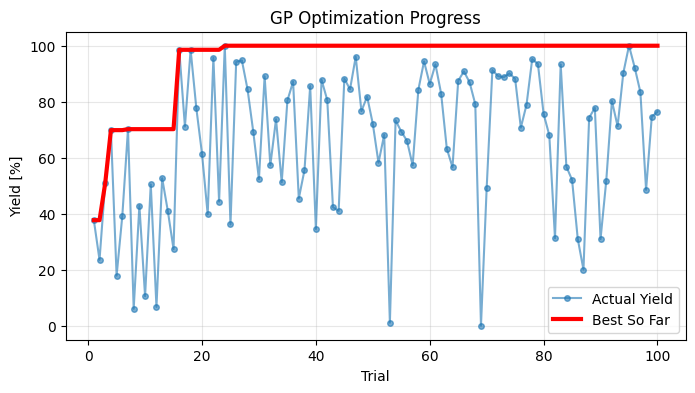

最適化履歴を ../runs/optuna_gp_100trials_NiB/visualization/optimization_progress.png に保存しました


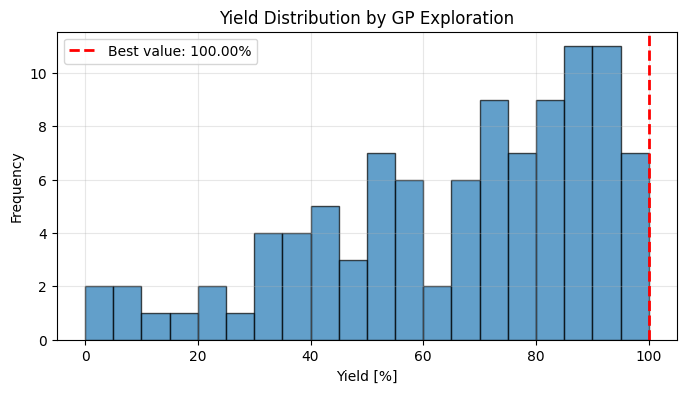

収率分布を ../runs/optuna_gp_100trials_NiB/visualization/yield_distribution.png に保存しました


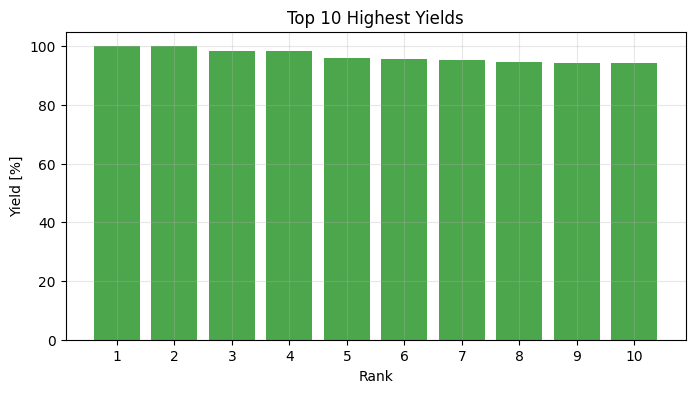

Top 10収率を ../runs/optuna_gp_100trials_NiB/visualization/top10_yields.png に保存しました


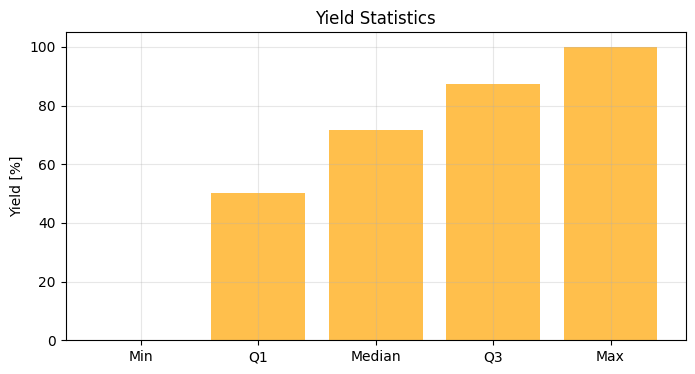

収率統計を ../runs/optuna_gp_100trials_NiB/visualization/yield_statistics.png に保存しました


In [14]:
plt.style.use('default')

# 1. 最適化履歴
fig = plt.figure(figsize=(8, 4))
plt.plot(range(1, len(trial_values)+1), trial_values, 'o-', alpha=0.6, label='Actual Yield', markersize=4)
plt.plot(range(1, len(trial_values)+1), best_values, 'r-', linewidth=3, label='Best So Far')
plt.xlabel('Trial')
plt.ylabel('Yield [%]')
plt.title('GP Optimization Progress')
plt.legend()
plt.grid(True, alpha=0.3)
fig.savefig(f"{viz_dir}/optimization_progress.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print(f"最適化履歴を {viz_dir}/optimization_progress.png に保存しました")

# 2. 収率分布
fig = plt.figure(figsize=(8, 4))
plt.hist(trial_values, bins=20, alpha=0.7, edgecolor='black')
plt.axvline(study.best_value, color='red', linestyle='--', linewidth=2, label=f'Best value: {study.best_value:.2f}%')
plt.xlabel('Yield [%]')
plt.ylabel('Frequency')
plt.title('Yield Distribution by GP Exploration')
plt.legend()
plt.grid(True, alpha=0.3)
fig.savefig(f"{viz_dir}/yield_distribution.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print(f"収率分布を {viz_dir}/yield_distribution.png に保存しました")

# 3. Top 10 収率
top_trials = sorted(study.trials, key=lambda t: t.value, reverse=True)[:10]
top_values = [t.value for t in top_trials]
top_indices = list(range(1, 11))

fig = plt.figure(figsize=(8, 4))
plt.bar(top_indices, top_values, alpha=0.7, color='green')
plt.xlabel('Rank')
plt.ylabel('Yield [%]')
plt.title('Top 10 Highest Yields')
plt.xticks(top_indices)
plt.grid(True, alpha=0.3)
fig.savefig(f"{viz_dir}/top10_yields.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print(f"Top 10収率を {viz_dir}/top10_yields.png に保存しました")

# 4. 収率の統計情報
stats_data = [np.min(trial_values), np.percentile(trial_values, 25), 
              np.median(trial_values), np.percentile(trial_values, 75), np.max(trial_values)]
stats_labels = ['Min', 'Q1', 'Median', 'Q3', 'Max']

fig = plt.figure(figsize=(8, 4))
plt.bar(stats_labels, stats_data, alpha=0.7, color='orange')
plt.ylabel('Yield [%]')
plt.title('Yield Statistics')
plt.grid(True, alpha=0.3)
fig.savefig(f"{viz_dir}/yield_statistics.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print(f"収率統計を {viz_dir}/yield_statistics.png に保存しました")